In [1]:
# general purpose libraries
import numpy as np
import datetime as dt
import pandas as pd
import os
import warnings
import pickle
from timeit import default_timer as timer
from collections import OrderedDict
from itertools import chain
from imblearn.over_sampling import SMOTE


# plots and visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as ply_go
import plotly.figure_factory as ply_ff
import plotly.colors as ply_colors #.sequential.Oranges as orange_palette
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment


# DSP libraries
from scipy import signal
import librosa
import librosa.display as librosa_display
from IPython.display import Audio

# ML and data modelling libraries
from sklearn.preprocessing   import MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, precision_recall_curve,confusion_matrix,precision_score, recall_score,average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression

# keras model
import keras
from keras import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.models import Sequential, model_from_json
from keras.initializers import he_normal, Zeros

C:\Users\ACER-E5\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load metadata

In [2]:
metadata = pd.read_csv('archive/metadata_compiled.csv')
metadata.columns

Index(['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
       'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
       'quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1',
       'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1',
       'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2',
       'choking_2', 'congestion_2', 'nothing_2', 'diagnosis_2', 'severity_2',
       'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3',
       'choking_3', 'congestion_3', 'nothing_3', 'diagnosis_3', 'severity_3',
       'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4',
       'choking_4', 'congestion_4', 'nothing_4', 'diagnosis_4', 'severity_4'],
      dtype='object')

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

In [4]:
# convert strings 'True'/'False' to genuine booleans
cols_to_boolean = (['respiratory_condition', 'fever_muscle_pain',
                     'dyspnea_1', 'wheezing_1', 'stridor_1','choking_1', 'congestion_1', 'nothing_1',
                     'dyspnea_2', 'wheezing_2', 'stridor_2','choking_2', 'congestion_2', 'nothing_2',
                     'dyspnea_3', 'wheezing_3', 'stridor_3','choking_3', 'congestion_3', 'nothing_3',
                     'dyspnea_4', 'wheezing_4', 'stridor_4','choking_4', 'congestion_4', 'nothing_4'])
for c in cols_to_boolean:
    metadata.loc[metadata[c].notnull(),c] = metadata.loc[metadata[c].notnull(),c].astype(bool)

In [5]:
metadata.isna().sum()

uuid                         0
datetime                     0
cough_detected               0
SNR                          0
latitude                 11466
longitude                11466
age                      12332
gender                   11326
respiratory_condition    11326
fever_muscle_pain        11326
status                   11326
quality_1                26730
cough_type_1             26748
dyspnea_1                26730
wheezing_1               26730
stridor_1                26730
choking_1                26730
congestion_1             26730
nothing_1                26730
diagnosis_1              26748
severity_1               26748
quality_2                26730
cough_type_2             26749
dyspnea_2                26730
wheezing_2               26730
stridor_2                26730
choking_2                26730
congestion_2             26730
nothing_2                26730
diagnosis_2              26748
severity_2               26748
quality_3                26730
cough_ty

In [6]:
df = metadata.copy()
cols_to_fillna = ['gender', 'age', 'status','diagnosis_1','diagnosis_2','diagnosis_3','diagnosis_4']
metadata[cols_to_fillna]=metadata[cols_to_fillna].fillna('n/a')

#### Hàm chuyển đổi file WAV

In [7]:
# Hàm chuyển đổi WebM thành WAV
def convert_webm_to_wav(input_path, output_path):
    audio = AudioSegment.from_file(input_path, format="webm")
    audio.export(output_path, format="wav")

In [8]:
def convert_ogg_to_wav(input_path, output_path):
    audio = AudioSegment.from_ogg(input_path)
    audio.export(output_path, format="wav")

## Visualize

#### Status: nhãn cần phân loại tiếng ho
Bộ dữ liệu gồm 3 loại nhãn sau:
- healthy: khoẻ mạnh
- COVID-19: Bệnh nhân tự báo cáo rằng đã được chẩn đoán mắc bệnh COVID-19
- symptomatic: có các triệu chứng nhưng không có chẩn đoán của bác sĩ


Cột status còn chứa giá trị 'n/a' đại diện cho giá trị bị thiếu

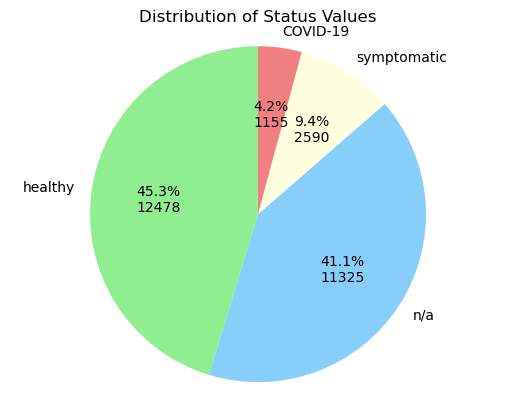

In [9]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột "status"
status_counts = metadata['status'].value_counts()

# Tạo danh sách màu tương ứng với số lượng giá trị
colors = ['lightgreen', 'lightskyblue', 'lightyellow', 'lightcoral']

fig, ax = plt.subplots()
ax.pie(status_counts, labels=status_counts.index, autopct=lambda p: '{:.1f}%\n{}'.format(p, int(p/100*sum(status_counts))),
       startangle=90, colors=colors)

# Thiết lập trung tâm và tỷ lệ trục x và y để đảm bảo biểu đồ tròn là hình tròn
ax.axis('equal')

plt.title('Distribution of Status Values')
plt.show()

Ta chỉ quan tâm tới các mẫu có nhãn status, vì vậy loại bỏ các mẫu có giá trị n/a

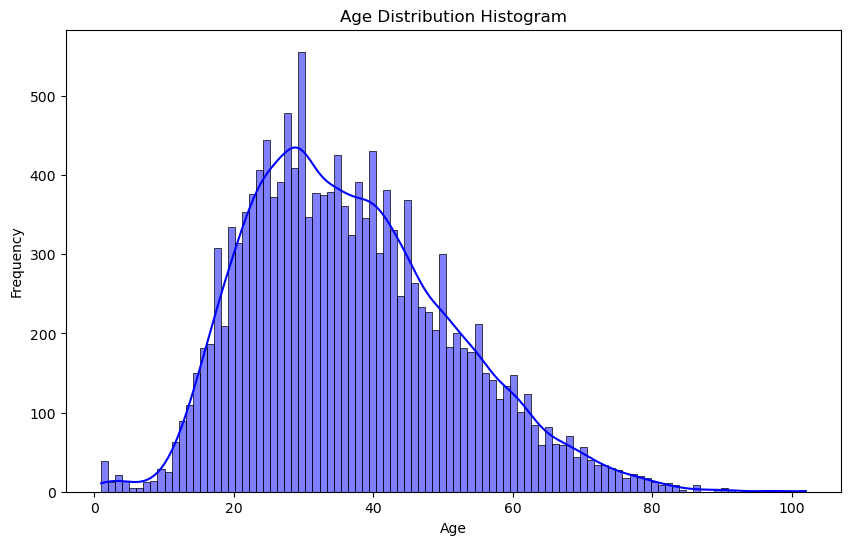

In [10]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['age'].dropna(), bins=100, kde=True, color='blue')

plt.title('Age Distribution Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

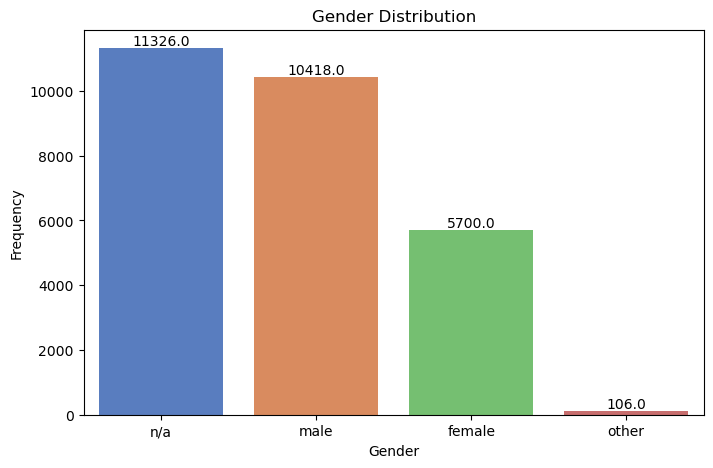

In [11]:
# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='gender', data=metadata, palette='muted')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')

# Thêm số lượng vào mỗi cột
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

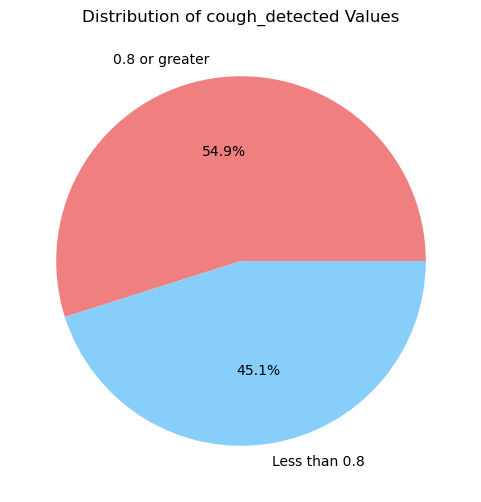

In [12]:
# Tạo hai nhóm dữ liệu dựa trên điều kiện
grouped_data = df['cough_detected'].apply(lambda x: 'Less than 0.8' if x < 0.8 else '0.8 or greater').value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])

plt.title('Distribution of cough_detected Values')
plt.show()

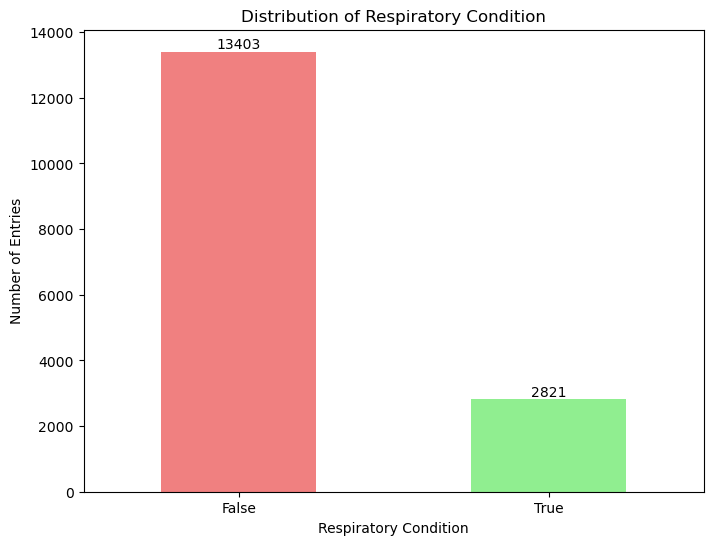

In [13]:
# Biểu đồ cột cho cột respiratory_condition sử dụng seaborn
plt.figure(figsize=(8, 6))
value_counts = metadata['respiratory_condition'].value_counts()
value_counts.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Distribution of Respiratory Condition')
plt.xlabel('Respiratory Condition')
plt.ylabel('Number of Entries')

# Thêm số lượng vào mỗi cột
for i, count in enumerate(value_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.show()

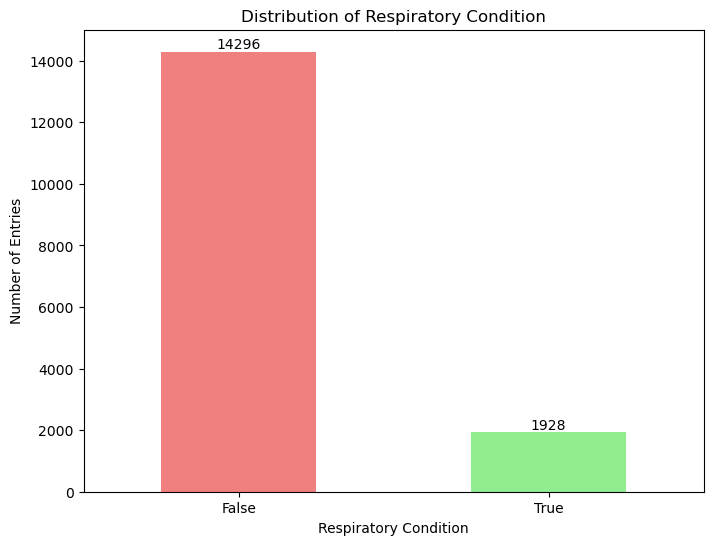

In [14]:
plt.figure(figsize=(8, 6))
value_counts = metadata['fever_muscle_pain'].value_counts()
value_counts.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Distribution of Respiratory Condition')
plt.xlabel('Respiratory Condition')
plt.ylabel('Number of Entries')

# Thêm số lượng vào mỗi cột
for i, count in enumerate(value_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.show()

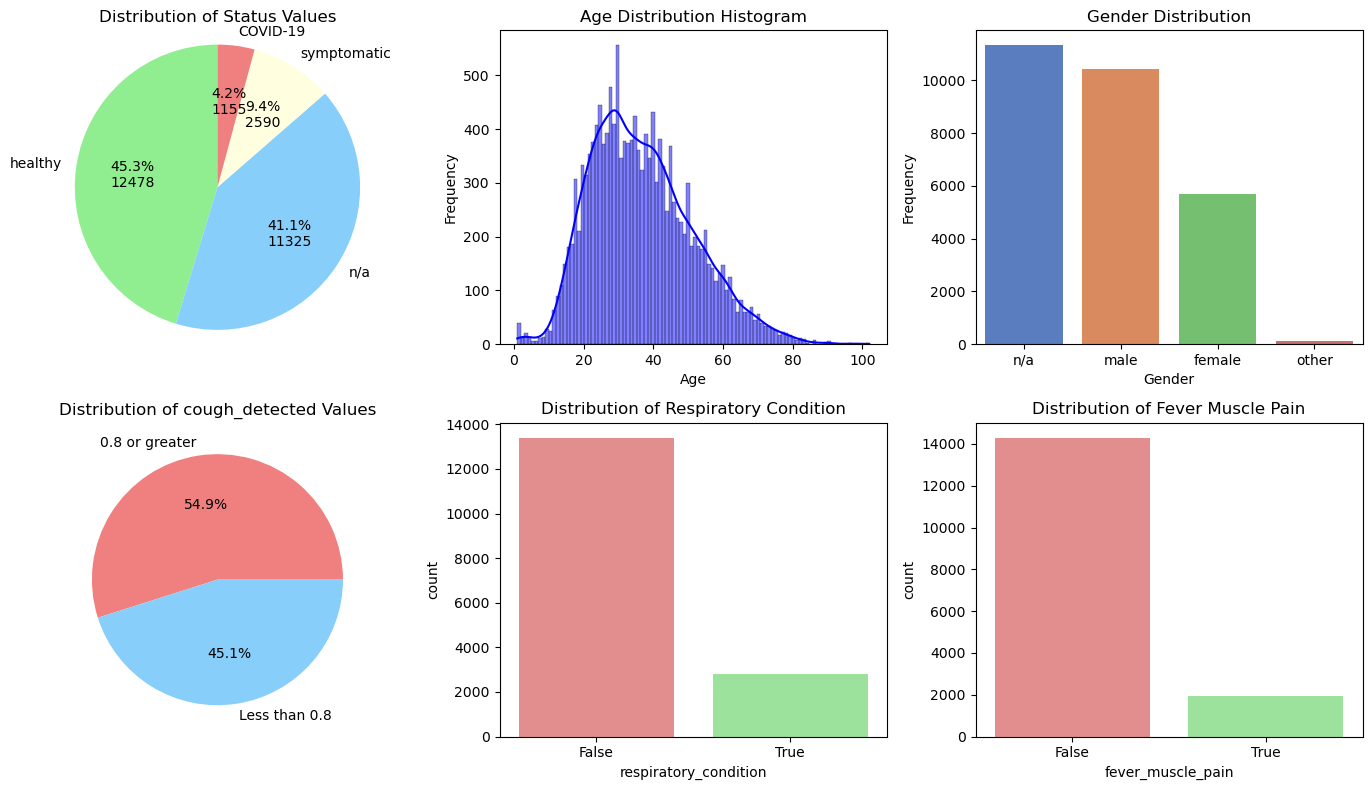

In [15]:
# Tạo lưới subplot 2x2
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# Biểu đồ 1
status_counts = metadata['status'].value_counts()
colors = ['lightgreen', 'lightskyblue', 'lightyellow', 'lightcoral']
axs[0, 0].pie(status_counts, labels=status_counts.index,
              autopct=lambda p: '{:.1f}%\n{}'.format(p, int(p/100*sum(status_counts))),
              startangle=90, colors=colors)
axs[0, 0].axis('equal')
axs[0, 0].set_title('Distribution of Status Values')

# Biểu đồ 2
sns.histplot(df['age'].dropna(), bins=100, kde=True, color='blue', ax=axs[0, 1])
axs[0, 1].set_title('Age Distribution Histogram')
axs[0, 1].set_xlabel('Age')
axs[0, 1].set_ylabel('Frequency')

# Biểu đồ 3
axs[0,2] = sns.countplot(x='gender', data=metadata, palette='muted', ax=axs[0, 2])
axs[0,2].set_title('Gender Distribution')
axs[0,2].set_xlabel('Gender')
axs[0,2].set_ylabel('Frequency')

# Thêm số lượng vào mỗi cột
for p in axs[0,2].patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Biểu đồ 4
grouped_data = df['cough_detected'].apply(lambda x: 'Less than 0.8' if x < 0.8 else '0.8 or greater').value_counts()
axs[1, 0].pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
axs[1, 0].set_title('Distribution of cough_detected Values')

# Biểu đồ 5 
axs[1, 1].set_title('Distribution of Respiratory Condition')
sns.countplot(x='respiratory_condition', data=metadata, palette=['lightcoral', 'lightgreen'], ax=axs[1, 1])

# Biểu đồ 6 
axs[1, 2].set_title('Distribution of Fever Muscle Pain')
sns.countplot(x='fever_muscle_pain', data=metadata, palette=['lightcoral', 'lightgreen'], ax=axs[1, 2])


# Tự động điều chỉnh layout để tránh trùng lặp
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [16]:
print("Metadata df entries before cleaning NAs: {}".format(metadata.shape[0]))
metadata = metadata[metadata['status'] != 'n/a']
print("Metadata df entries after cleaning NAs: {}".format(metadata.shape[0]))

Metadata df entries before cleaning NAs: 27550
Metadata df entries after cleaning NAs: 16224


In [17]:
metadata[(metadata['cough_detected']>=0.8) & (metadata['SNR']>80) & (metadata['status']=='healthy')]

uuid                          datetime  \
1123   0ac3fe38-6168-4170-9e71-697b93d42297  2020-10-20T15:14:26.153383+00:00   
1744   1064c7ac-1277-40e8-99c9-8803ebcf1fae  2020-11-02T12:56:39.863399+00:00   
5290   31884439-269c-440e-8bf8-a8240bbe8cbe  2020-05-03T09:43:21.415457+00:00   
6296   3abec008-3495-487f-8571-8c6f9b9d8682  2020-11-01T23:24:10.551640+00:00   
10113  5e38be03-30af-433c-acf4-4d77f4416301  2020-11-30T09:06:00.845307+00:00   
10680  63779d92-f15e-4e56-b37c-31ca4b2c9c34  2020-09-22T18:12:08.205031+00:00   
15799  92c04890-cf04-4042-9d15-798b2152386f  2020-11-05T18:36:52.821879+00:00   
16177  96644b82-b1a1-4db8-bedc-50627bbebaf9  2020-10-18T19:34:52.817671+00:00   
18935  b09a8fb8-6dda-44ea-acab-6d5c86ba75c7  2020-11-25T18:56:56.172189+00:00   
19337  b4229630-0475-4cf3-a6bf-b72da4fb7365  2020-11-24T12:07:22.163212+00:00   
21030  c398c9bc-7fb4-4e1a-abb0-28aa402f0667  2020-11-14T15:08:04.689520+00:00   
22162  ce8a2e1c-43fc-45d9-9a72-1430d4330009  2020-04-13T18:54:28.414955+00:00   
23053  d687f6dd-770d-4f8a-9789-1d78b33ddea0  2020-04-19T08:05:09.124282+00:00   
23509  daba93c4-8097-4bc4-b704-702d7e37fd00  2020-04-13T18:30:33.200939+00:00   

       cough_detected         SNR  latitude  longitude   age  gender  \
1123           0.9588   87.115593       NaN        NaN  21.0  female   
1744           0.9811   80.046396      43.6        7.0  53.0  female   
5290           0.9498   81.420746       NaN        NaN  37.0    male   
6296           0.9710  100.175018      48.8        2.2  43.0    male   
10113          0.9694         inf       9.9       43.2  23.0    male   
10680          0.9145         inf       NaN        NaN  99.0  female   
15799          0.9576   89.407520      43.3       -2.0  34.0  female   
16177          0.9233   99.337158      47.3        5.0  66.0  female   
18935          0.9723         inf      47.3        5.1  13.0    male   
19337          0.9429   82.395353      52.5       13.5  39.0    male   
21030          0.9901   83.360748       NaN        NaN  30.0  female   
22162          0.9731   84.063358       NaN        NaN  38.0  female   
23053          0.8266   83.425608       NaN        NaN  29.0    male   
23509          0.9934   87.749844      39.9       32.7  24.0    male   

      respiratory_condition fever_muscle_pain  ... quality_4 cough_type_4  \
1123                  False             False  ...       NaN          NaN   
1744                  False             False  ...       NaN          NaN   
5290                  False             False  ...       NaN          NaN   
6296                   True             False  ...       NaN          NaN   
10113                  True             False  ...       NaN          NaN   
10680                 False             False  ...       NaN          NaN   
15799                 False             False  ...       NaN          NaN   
16177                 False             False  ...       NaN          NaN   
18935                 False             False  ...       NaN          NaN   
19337                 False             False  ...       NaN          NaN   
21030                 False             False  ...       NaN          NaN   
22162                 False             False  ...       NaN          NaN   
23053                 False             False  ...       NaN          NaN   
23509                 False             False  ...       NaN          NaN   

      dyspnea_4 wheezing_4 stridor_4 choking_4 congestion_4 nothing_4  \
1123        NaN        NaN       NaN       NaN          NaN       NaN   
1744        NaN        NaN       NaN       NaN          NaN       NaN   
5290        NaN        NaN       NaN       NaN          NaN       NaN   
6296        NaN        NaN       NaN       NaN          NaN       NaN   
10113       NaN        NaN       NaN       NaN          NaN       NaN   
10680       NaN        NaN       NaN       NaN          NaN       NaN   
15799       NaN        NaN       NaN       NaN          NaN       NaN   
16

Status: COVID-19 
SNR: 83.01593781
Signal shape: (72765,)
Sample Rate: 22050
Duration: 3.3 giây


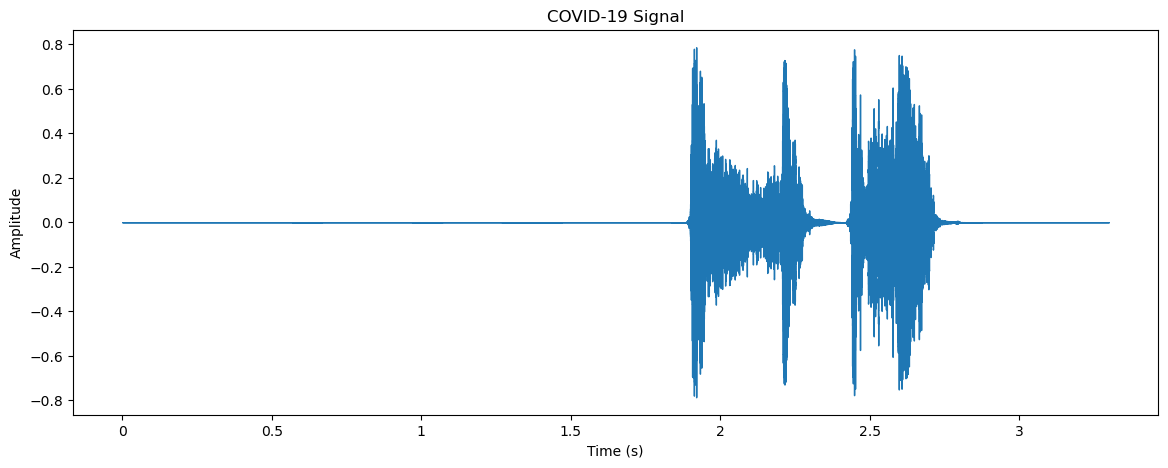

In [18]:
uuid ='56994aa1-4626-4782-9f27-f125adfd120a'
sample = metadata[metadata['uuid']==uuid]
sample = sample.reset_index(drop=True)
print('Status:', sample['status'].iloc[0], '\nSNR:', sample['SNR'].iloc[0])

#load audio file
tmp_audiofilename_webm = "archive/"+uuid+".webm"
tmp_audiofilename_wav = "archive/"+uuid+".wav"
convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
print('Signal shape:', t.shape)
print('Sample Rate:', sr)

# Tính độ dài của t trong giây
duration_seconds = len(t) / sr
print('Duration:', duration_seconds, 'giây')

# Trực quan hóa tín hiệu âm thanh
plt.figure(figsize=(14, 5))
librosa.display.waveshow(t, sr=sr)
plt.title('COVID-19 Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Sử dụng IPython.display.Audio để phát âm thanh
audio_widget = Audio(t, rate=sr)
audio_widget

Status: symptomatic 
SNR: 82.80946732
Signal shape: (116424,)
Sample Rate: 22050
Duration: 5.28 giây


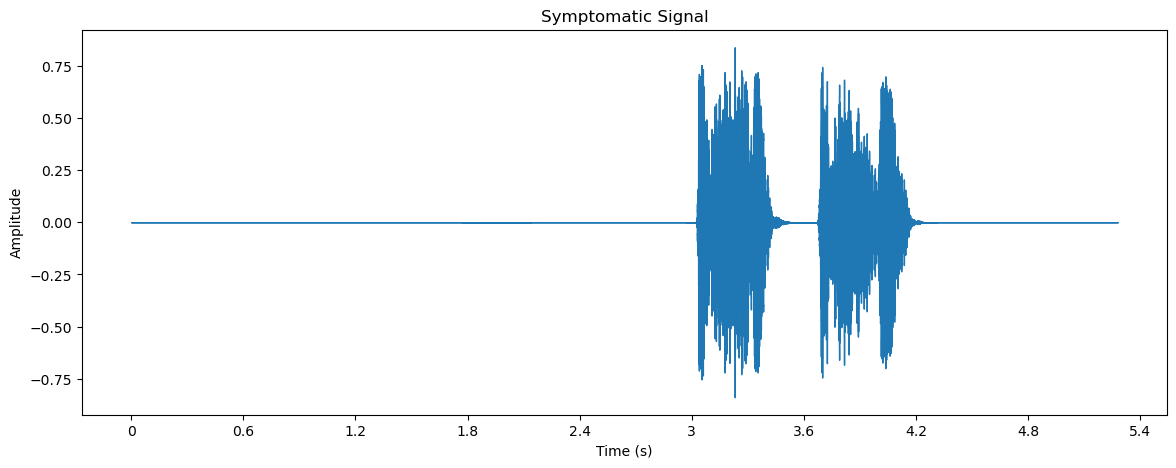

In [19]:
uuid = 'a61dc6d6-2367-4179-92af-652e96b272d6'
sample = metadata[metadata['uuid']==uuid]
sample = sample.reset_index(drop=True)
print('Status:', sample['status'].iloc[0], '\nSNR:', sample['SNR'].iloc[0])

#load audio file
tmp_audiofilename_webm = "archive/"+uuid+".webm"
tmp_audiofilename_wav = "archive/"+uuid+".wav"
convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
print('Signal shape:', t.shape)
print('Sample Rate:', sr)

# Tính độ dài của t trong giây
duration_seconds = len(t) / sr
print('Duration:', duration_seconds, 'giây')

# Trực quan hóa tín hiệu âm thanh
plt.figure(figsize=(14, 5))
librosa.display.waveshow(t, sr=sr)
plt.title('Symptomatic Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Sử dụng IPython.display.Audio để phát âm thanh
audio_widget = Audio(t, rate=sr)
audio_widget

Status: healthy 
SNR: 81.42074585
Signal shape: (218295,)
Sample Rate: 22050
Duration: 9.9 giây


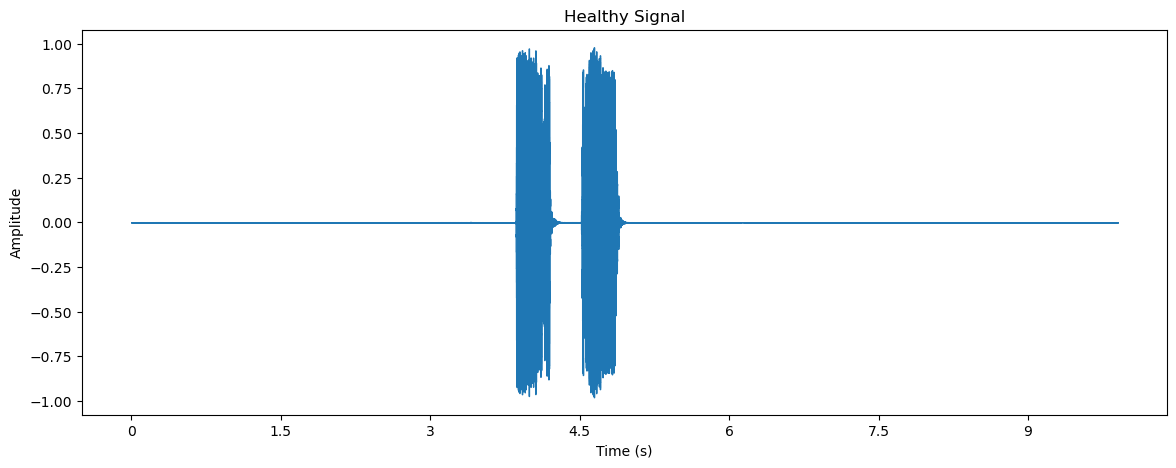

In [20]:
uuid = '31884439-269c-440e-8bf8-a8240bbe8cbe'
sample = metadata[metadata['uuid']==uuid]
sample = sample.reset_index(drop=True)
print('Status:', sample['status'].iloc[0], '\nSNR:', sample['SNR'].iloc[0])

#load audio file
tmp_audiofilename_webm = "archive/"+uuid+".webm"
tmp_audiofilename_wav = "archive/"+uuid+".wav"
convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
print('Signal shape:', t.shape)
print('Sample Rate:', sr)

# Tính độ dài của t trong giây
duration_seconds = len(t) / sr
print('Duration:', duration_seconds, 'giây')

# Trực quan hóa tín hiệu âm thanh
plt.figure(figsize=(14, 5))
librosa.display.waveshow(t, sr=sr)
plt.title('Healthy Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Sử dụng IPython.display.Audio để phát âm thanh
audio_widget = Audio(t, rate=sr)
audio_widget

#### Cough_detected: phát hiện tiếng ho trong bảng ghi
Giá trị càng lớn, bản ghi chứa tiếng ho càng nhiều. Bài báo về bộ dữ liệu khuyên nên lấy cough_detected >= 0.8

In [21]:
# Vẽ histogram cho cột "cough_detected"
fig = px.histogram(metadata, x='cough_detected', nbins=int((1-0)/0.01), title='Cough Detected Scores')

# Thiết lập các trục và tiêu đề
fig.update_layout(xaxis_title='Cough Detected', yaxis_title='Frequency')

# Hiển thị histogram
fig.show()

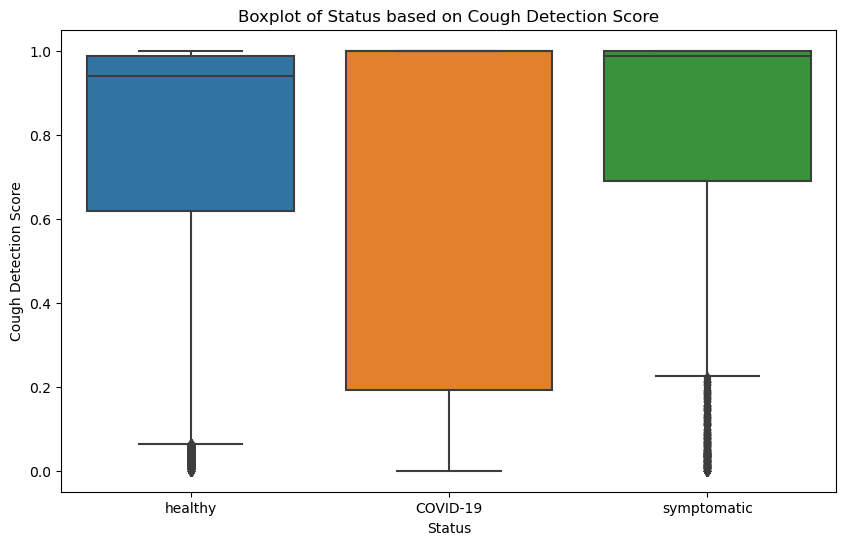

In [22]:
# Vẽ boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y='cough_detected', x='status', data=metadata)

# Đặt tên trục và tiêu đề
plt.ylabel('Cough Detection Score')
plt.xlabel('Status')
plt.title('Boxplot of Status based on Cough Detection Score')

# Hiển thị hình vẽ
plt.show()

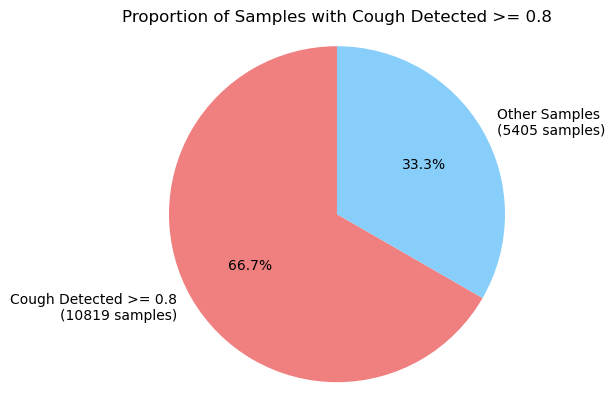

In [23]:
# Lọc dữ liệu theo điều kiện cough_detected >= 0.8
filtered_df = metadata[metadata['cough_detected'] >= 0.8]

# Số lượng mẫu có cough_detected >= 0.8
num_samples = len(filtered_df)

# Số lượng mẫu tổng thể
total_samples = len(metadata)

# Tạo biểu đồ
labels = [f'Cough Detected >= 0.8\n({num_samples} samples)', f'Other Samples\n({total_samples - num_samples} samples)']
sizes = [num_samples, total_samples - num_samples]
colors = ['lightcoral', 'lightskyblue']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Proportion of Samples with Cough Detected >= 0.8')
plt.show()

In [24]:
print("Metadata df entries before filtering cough_detected >= 0.8: {}".format(metadata.shape[0]))
metadata = metadata[metadata['cough_detected'] >= 0.8]
print("Metadata df entries after filtering cough_detected >= 0.8: {}".format(metadata.shape[0]))

Metadata df entries before filtering cough_detected >= 0.8: 16224
Metadata df entries after filtering cough_detected >= 0.8: 10819


#### SNR - Signal to noise Ratio: tỉ lệ tín hiệu nhiễu
Trong ngữ cảnh của âm thanh, SNR thường được sử dụng để đo lường chất lượng âm thanh. SNR được đo bằng đơn vị decibel (dB), và giá trị SNR càng lớn, tín hiệu càng mạnh hơn so với nhiễu, điều này thường được coi là tốt. Ngược lại, nếu SNR thấp, tín hiệu sẽ bị chìm trong nhiễu và trở nên khó phân biệt.

In [25]:
# Vẽ histogram cho cột "SNR" của dữ liệu đã lọc
fig = px.histogram(metadata, x='SNR', nbins=100, title='SNR with Cough Detected >= 0.8')

# Thiết lập các trục và tiêu đề
fig.update_layout(xaxis_title='SNR', yaxis_title='Frequency')

# Hiển thị histogram
fig.show()

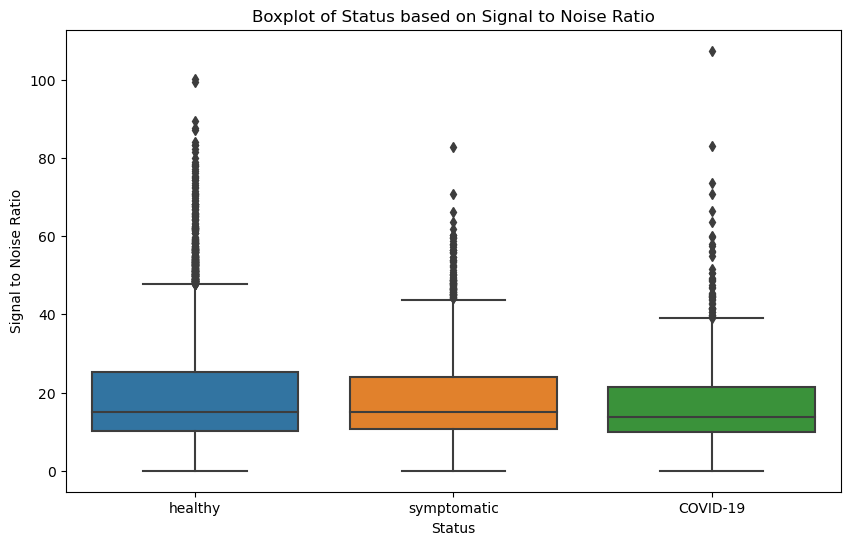

In [26]:
# Vẽ boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y='SNR', x='status', data=metadata)

# Đặt tên trục và tiêu đề
plt.ylabel('Signal to Noise Ratio')
plt.xlabel('Status')
plt.title('Boxplot of Status based on Signal to Noise Ratio')

# Hiển thị hình vẽ
plt.show()

Trực quan hoá một bản ghi có giá trị SNR cao

Status: COVID-19 
SNR: 83.01593781
Signal shape: (72765,)
Sample Rate: 22050
Duration: 3.3 giây


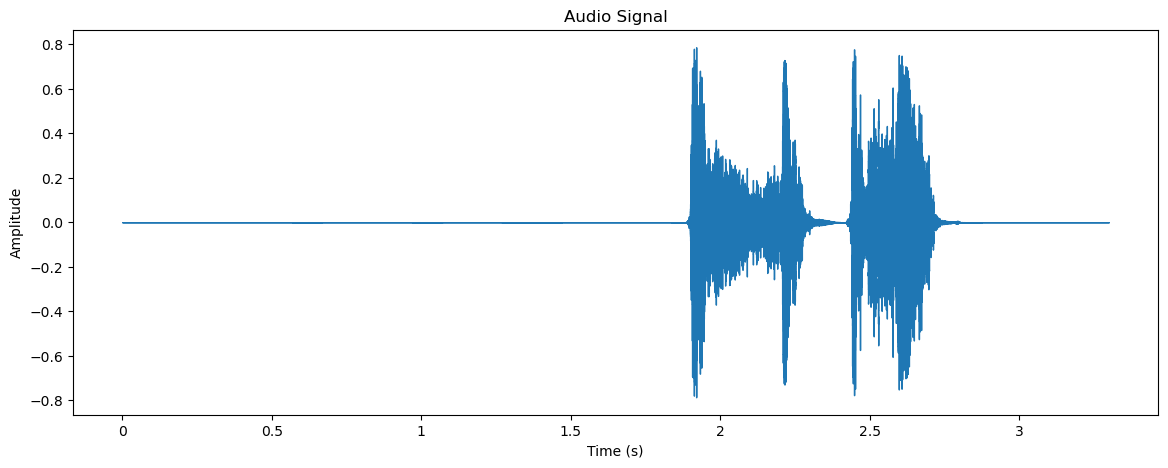

In [27]:
uuid = '56994aa1-4626-4782-9f27-f125adfd120a'
sample = metadata[metadata['uuid']==uuid]
sample = sample.reset_index(drop=True)
print('Status:', sample['status'].iloc[0], '\nSNR:', sample['SNR'].iloc[0])

#load audio file
tmp_audiofilename_webm = "archive/"+uuid+".webm"
tmp_audiofilename_wav = "archive/"+uuid+".wav"
convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
print('Signal shape:', t.shape)
print('Sample Rate:', sr)

# Tính độ dài của t trong giây
duration_seconds = len(t) / sr
print('Duration:', duration_seconds, 'giây')

# Trực quan hóa tín hiệu âm thanh
plt.figure(figsize=(14, 5))
librosa.display.waveshow(t, sr=sr)
plt.title('Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Sử dụng IPython.display.Audio để phát âm thanh
audio_widget = Audio(t, rate=sr)
audio_widget

Trực quan hoá bản ghi có SNR thấp

Status: COVID-19 
SNR: 0.0
Signal shape: (100548,)
Sample Rate: 22050
Duration: 4.56 giây


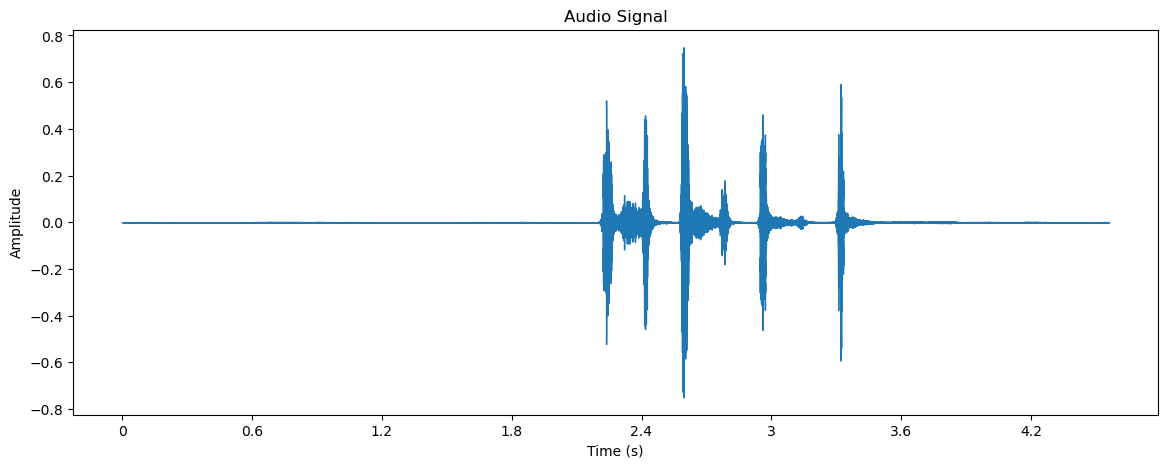

In [28]:
uuid = 'e8a4c9ee-66e8-473c-9f1b-40918a92a928'
sample = metadata[metadata['uuid']==uuid]
sample = sample.reset_index(drop=True)
print('Status:', sample['status'].iloc[0], '\nSNR:', sample['SNR'].iloc[0])

#load audio file
tmp_audiofilename_webm = "archive/"+uuid+".webm"
tmp_audiofilename_wav = "archive/"+uuid+".wav"
convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
print('Signal shape:', t.shape)
print('Sample Rate:', sr)

# Tính độ dài của t trong giây
duration_seconds = len(t) / sr
print('Duration:', duration_seconds, 'giây')

# Trực quan hóa tín hiệu âm thanh
plt.figure(figsize=(14, 5))
librosa.display.waveshow(t, sr=sr)
plt.title('Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Sử dụng IPython.display.Audio để phát âm thanh
audio_widget = Audio(t, rate=sr)
audio_widget

Status: COVID-19 
SNR: 9.685268998
Signal shape: (100548,)
Sample Rate: 22050
Duration: 4.56 giây


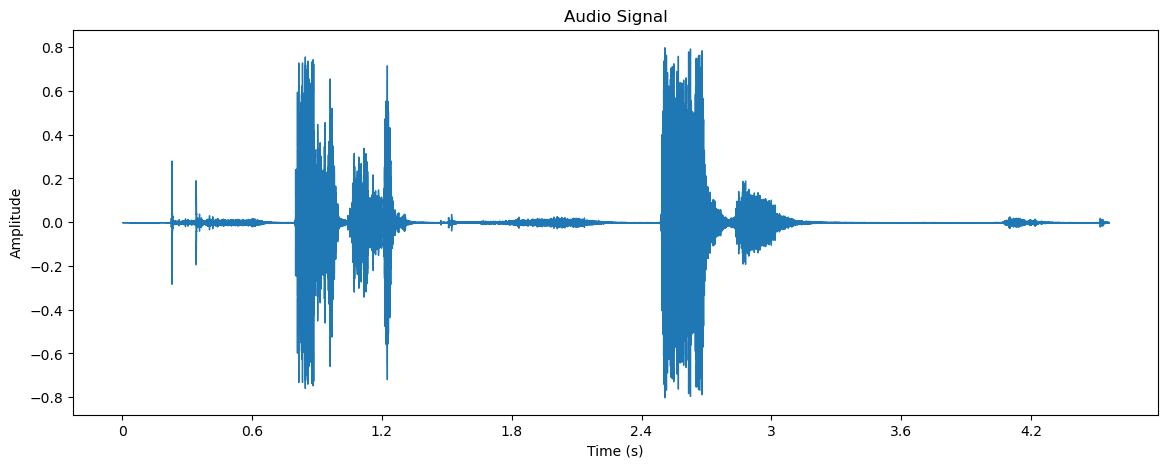

In [29]:
uuid = 'f7d1f28a-e3a8-4dd9-b7ec-93e04ee023a0'
sample = metadata[metadata['uuid']==uuid]
sample = sample.reset_index(drop=True)
print('Status:', sample['status'].iloc[0], '\nSNR:', sample['SNR'].iloc[0])

#load audio file
tmp_audiofilename_webm = "archive/"+uuid+".webm"
tmp_audiofilename_wav = "archive/"+uuid+".wav"
convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
print('Signal shape:', t.shape)
print('Sample Rate:', sr)

# Tính độ dài của t trong giây
duration_seconds = len(t) / sr
print('Duration:', duration_seconds, 'giây')

# Trực quan hóa tín hiệu âm thanh
plt.figure(figsize=(14, 5))
librosa.display.waveshow(t, sr=sr)
plt.title('Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Sử dụng IPython.display.Audio để phát âm thanh
audio_widget = Audio(t, rate=sr)
audio_widget

#### respiratory_condition: Bệnh nhân có tình trạng hô hấp khác hay không

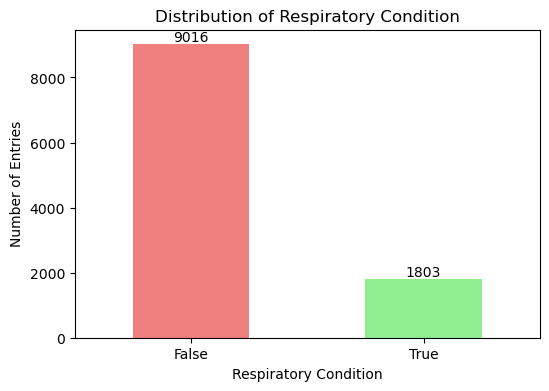

In [30]:
# Biểu đồ cột cho cột respiratory_condition sử dụng seaborn
plt.figure(figsize=(6, 4))
value_counts = metadata['respiratory_condition'].value_counts()
value_counts.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Distribution of Respiratory Condition')
plt.xlabel('Respiratory Condition')
plt.ylabel('Number of Entries')

# Thêm số lượng vào mỗi cột
for i, count in enumerate(value_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.show()

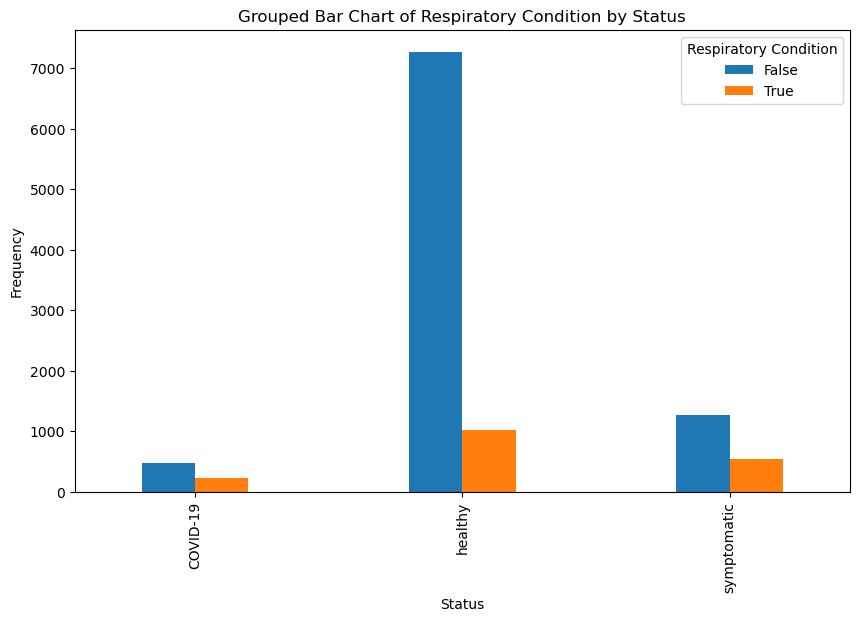

In [31]:
# Tạo bảng tần suất
table = pd.crosstab(metadata['status'], metadata['respiratory_condition'])

# Vẽ biểu đồ cột nhóm
ax = table.plot(kind='bar', figsize=(10, 6), width=0.4)

# Đặt tên trục và tiêu đề
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Grouped Bar Chart of Respiratory Condition by Status')

# Đặt vị trí các nhóm cột
ax.set_xticks(range(len(table.index)))
ax.set_xticklabels(table.index)

# Hiển thị chú thích
plt.legend(title='Respiratory Condition')

# Hiển thị biểu đồ
plt.show()

#### fever_muscle_pain: Bệnh nhân sốt hoặc đau cơ hay không

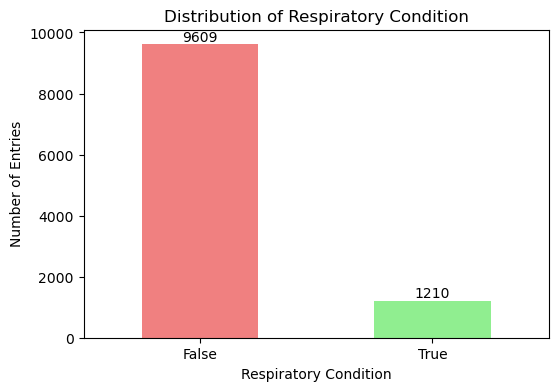

In [32]:
plt.figure(figsize=(6, 4))
value_counts = metadata['fever_muscle_pain'].value_counts()
value_counts.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Distribution of Respiratory Condition')
plt.xlabel('Respiratory Condition')
plt.ylabel('Number of Entries')

# Thêm số lượng vào mỗi cột
for i, count in enumerate(value_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.show()

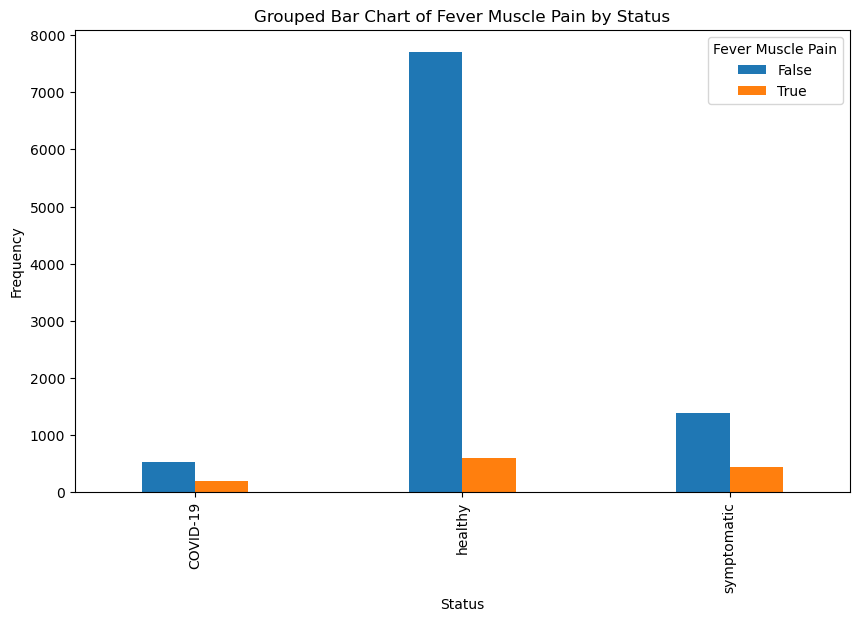

In [33]:
# Tạo bảng tần suất
table = pd.crosstab(metadata['status'], metadata['fever_muscle_pain'])

# Vẽ biểu đồ cột nhóm
ax = table.plot(kind='bar', figsize=(10, 6), width=0.4)

# Đặt tên trục và tiêu đề
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Grouped Bar Chart of Fever Muscle Pain by Status')

# Đặt vị trí các nhóm cột
ax.set_xticks(range(len(table.index)))
ax.set_xticklabels(table.index)

# Hiển thị chú thích
plt.legend(title='Fever Muscle Pain')

# Hiển thị biểu đồ
plt.show()

#### Tỷ lệ các nhãn sau bước visualize và cutdown data

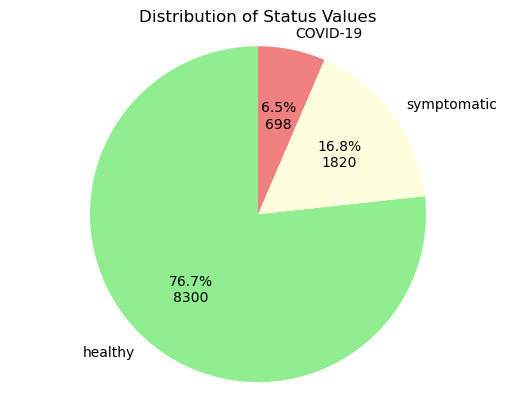

In [34]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột "status"
status_counts = metadata['status'].value_counts()

# Tạo danh sách màu tương ứng với số lượng giá trị
colors = ['lightgreen', 'lightyellow', 'lightcoral']

fig, ax = plt.subplots()
ax.pie(status_counts, labels=status_counts.index, autopct=lambda p: '{:.1f}%\n{}'.format(p, int(p/100*sum(status_counts))),
       startangle=90, colors=colors)

# Thiết lập trung tâm và tỷ lệ trục x và y để đảm bảo biểu đồ tròn là hình tròn
ax.axis('equal')

plt.title('Distribution of Status Values')
plt.show()

#### Visualize 4 mẫu COVID-19 ngẫu nhiên

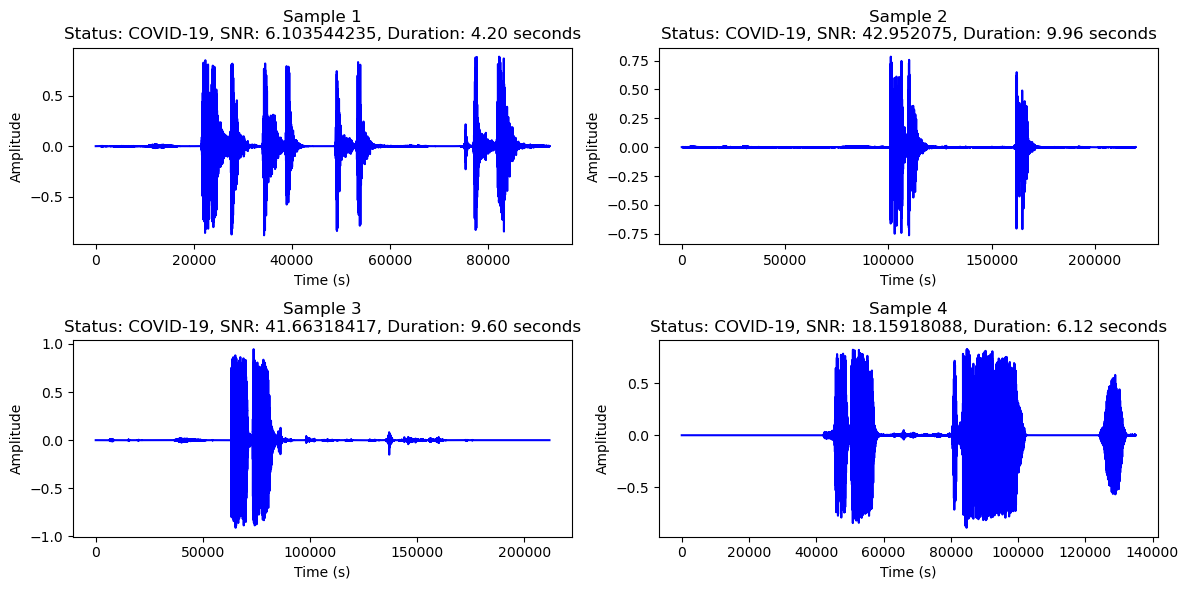

In [35]:
# Lấy ngẫu nhiên 4 mẫu có status = 'COVID19'
covid_samples = metadata[metadata['status'] == 'COVID-19'].sample(n=4, random_state=10)

# Tạo subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Lặp qua từng mẫu trong covid_samples
for idx, sample_uuid in enumerate(covid_samples['uuid']):
    sample = metadata[metadata['uuid'] == sample_uuid].reset_index(drop=True)

    # Load audio file
    tmp_audiofilename_webm = "archive/" + sample_uuid + ".webm"
    tmp_audiofilename_wav = "archive/" + sample_uuid + ".wav"
    convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
    t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
    
    # Tính độ dài của t trong giây
    duration_seconds = len(t) / sr

    # Trực quan hóa tín hiệu âm thanh trên subplot tương ứng
    row = idx // 2  # Xác định dòng (0 hoặc 1)
    col = idx % 2   # Xác định cột (0 hoặc 1)
    axs[row, col].plot(t, color='blue')
    axs[row, col].set_title(f'Sample {idx + 1}\nStatus: {sample["status"].iloc[0]}, SNR: {sample["SNR"].iloc[0]}, Duration: {duration_seconds:.2f} seconds')
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Amplitude')

# Tự động điều chỉnh layout để tránh trùng lặp
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

#### Visualize 4 mẫu symptomatic ngẫu nhiên

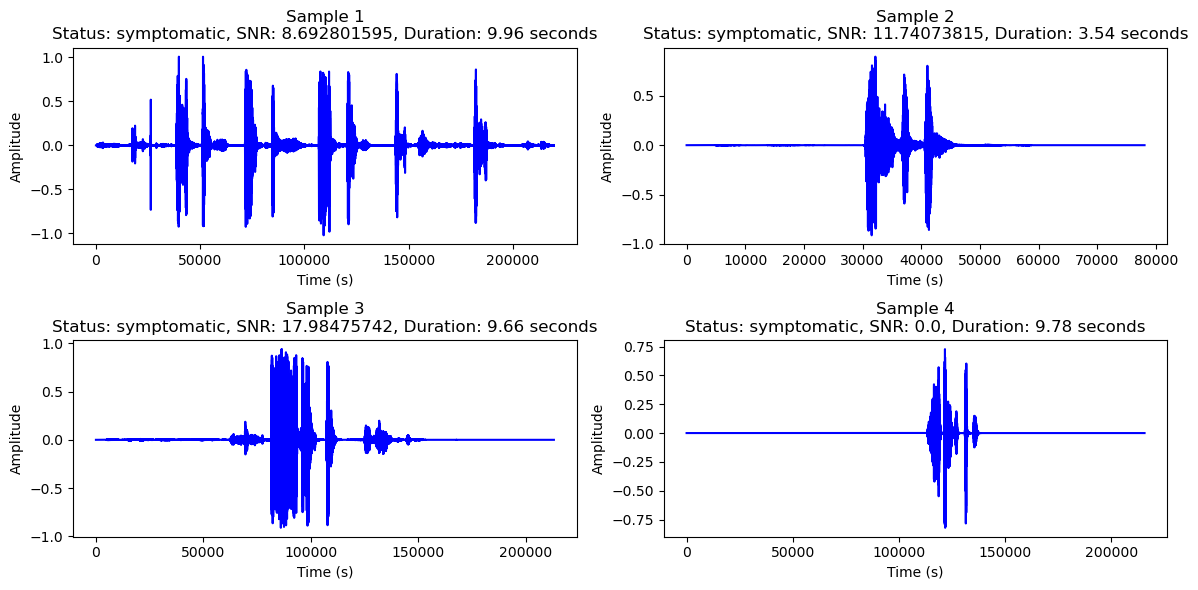

In [36]:
# Lấy ngẫu nhiên 4 mẫu có status = 'symptomatic'
covid_samples = metadata[metadata['status'] == 'symptomatic'].sample(n=4, random_state=10)

# Tạo subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Lặp qua từng mẫu trong covid_samples
for idx, sample_uuid in enumerate(covid_samples['uuid']):
    sample = metadata[metadata['uuid'] == sample_uuid].reset_index(drop=True)

    # Load audio file
    tmp_audiofilename_webm = "archive/" + sample_uuid + ".webm"
    tmp_audiofilename_wav = "archive/" + sample_uuid + ".wav"
    convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
    t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
    
    # Tính độ dài của t trong giây
    duration_seconds = len(t) / sr

    # Trực quan hóa tín hiệu âm thanh trên subplot tương ứng
    row = idx // 2  # Xác định dòng (0 hoặc 1)
    col = idx % 2   # Xác định cột (0 hoặc 1)
    axs[row, col].plot(t, color='blue')
    axs[row, col].set_title(f'Sample {idx + 1}\nStatus: {sample["status"].iloc[0]}, SNR: {sample["SNR"].iloc[0]}, Duration: {duration_seconds:.2f} seconds')
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Amplitude')

# Tự động điều chỉnh layout để tránh trùng lặp
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

#### Visualize 4 mẫu healthy ngẫu nhiên

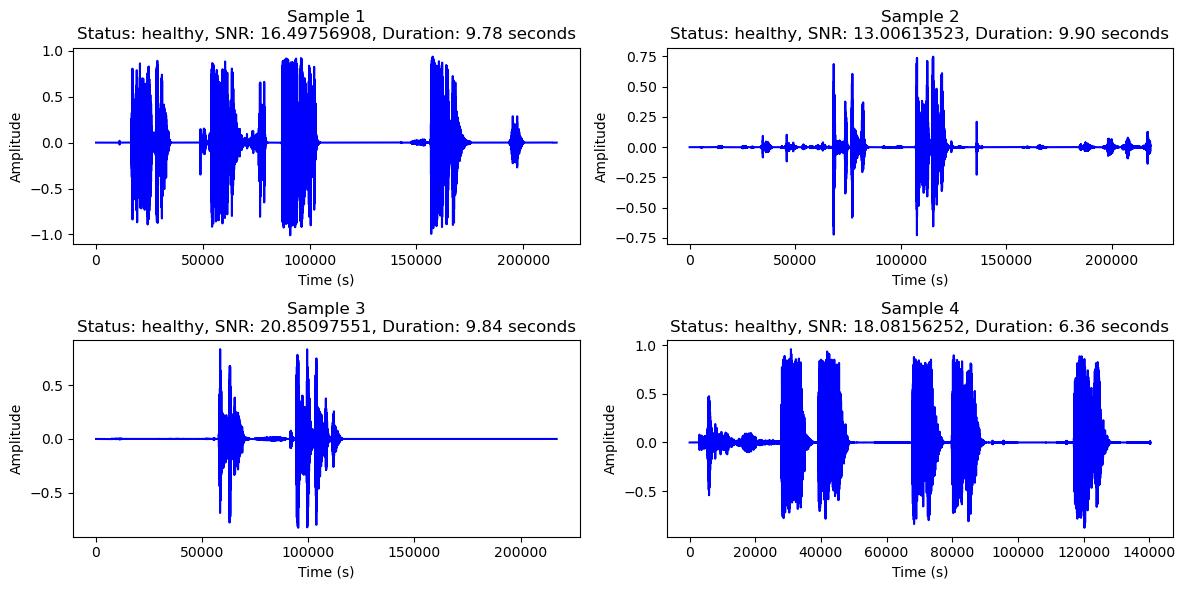

In [37]:
# Lấy ngẫu nhiên 4 mẫu có status = 'healthy'
covid_samples = metadata[metadata['status'] == 'healthy'].sample(n=4, random_state=10)

# Tạo subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Lặp qua từng mẫu trong covid_samples
for idx, sample_uuid in enumerate(covid_samples['uuid']):
    sample = metadata[metadata['uuid'] == sample_uuid].reset_index(drop=True)

    # Load audio file
    tmp_audiofilename_webm = "archive/" + sample_uuid + ".webm"
    tmp_audiofilename_wav = "archive/" + sample_uuid + ".wav"
    convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
    t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
    
    # Tính độ dài của t trong giây
    duration_seconds = len(t) / sr

    # Trực quan hóa tín hiệu âm thanh trên subplot tương ứng
    row = idx // 2  # Xác định dòng (0 hoặc 1)
    col = idx % 2   # Xác định cột (0 hoặc 1)
    axs[row, col].plot(t, color='blue')
    axs[row, col].set_title(f'Sample {idx + 1}\nStatus: {sample["status"].iloc[0]}, SNR: {sample["SNR"].iloc[0]}, Duration: {duration_seconds:.2f} seconds')
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Amplitude')

# Tự động điều chỉnh layout để tránh trùng lặp
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

## Xử lý bảng metadata trước khi trích xuất đặc trưng

Sau các bước ở trên, lúc này bảng metadata gồm những đặc trưng sau:
- Không có nan value tại cột status
- Không có nan value tại cột age
- Các mẫu đều có giá trị cough_detected >= 0.8

Kích thước metadata là (10819,52)

#### Chuyển các bản ghi thành dạng .WAV

In [38]:
count = 0
all_uuids = metadata['uuid'].values
for uuid in all_uuids:
    tmp_audiofilename_webm = "archive/"+uuid+".webm"
    tmp_audiofilename_wav = "archive/"+uuid+".wav"
    if not os.path.exists(tmp_audiofilename_webm):
        # try to look for a .ogg file
        tmp_audiofilename_ogg = "archive/"+uuid+".ogg"
        convert_ogg_to_wav(tmp_audiofilename_ogg, tmp_audiofilename_wav)
    else: 
        convert_webm_to_wav(tmp_audiofilename_webm, tmp_audiofilename_wav)
    count += 1
    if count%1000 == 0:
        print(count)

print('All .wav file:', count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
All .wav file: 10819


In [39]:
metadata

uuid                          datetime  \
1      00039425-7f3a-42aa-ac13-834aaa2b6b92  2020-04-13T21:30:59.801831+00:00   
3      0009eb28-d8be-4dc1-92bb-907e53bc5c7a  2020-04-12T04:02:18.159383+00:00   
5      001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  2020-04-13T22:23:06.997578+00:00   
10     0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952  2020-05-24T12:12:46.394647+00:00   
11     00291cce-36a0-4a29-9e2d-c1d96ca17242  2020-04-13T15:10:58.405156+00:00   
...                                     ...                               ...   
27535  ffd42893-4119-4855-9aad-c67d8d392cc1  2020-04-11T12:44:37.495743+00:00   
27539  ffe0658f-bade-4654-ad79-40a468aabb03  2020-04-14T01:58:32.200245+00:00   
27540  ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1  2020-04-13T21:08:50.708320+00:00   
27542  ffedc843-bfc2-4ad6-a749-2bc86bdac84a  2020-06-05T03:41:37.481463+00:00   
27543  ffeea120-92a4-40f9-b692-c3865c7a983f  2020-05-02T10:18:27.348859+00:00   

       cough_detected        SNR  latitude  longitude   age  gender  \
1              0.9609  16.151433      31.3       34.8  15.0    male   
3              0.9301  20.146058      40.0      -75.1  34.0    male   
5              0.9968  13.146502       NaN        NaN  21.0    male   
10             0.8937  13.477551       NaN        NaN  28.0  female   
11             0.9883  14.603851      39.4       67.2  15.0    male   
...               ...        ...       ...        ...   ...     ...   
27535          0.9414  28.530965       NaN        NaN  26.0    male   
27539          1.0000  21.960583      41.6       60.9  22.0    male   
27540          0.9485   9.966762      41.1       28.8  31.0    male   
27542          1.0000  33.661082     -34.5      -58.5  23.0    male   
27543          0.9784   9.635425      14.3      121.1  22.0  female   

      respiratory_condition fever_muscle_pain  ... quality_4 cough_type_4  \
1                     False             False  ...       NaN          NaN   
3                      True             False  ...       NaN          NaN   
5                     False             False  ...       NaN          NaN   
10                    False             False  ...       NaN          NaN   
11                    False             False  ...       NaN          NaN   
...                     ...               ...  ...       ...          ...   
27535                 False             False  ...       NaN          NaN   
27539                  True              True  ...      poor      unknown   
27540                 False             False  ...       NaN          NaN   
27542                 False             False  ...      good          dry   
27543                 False             False  ...       NaN          NaN   

      dyspnea_4 wheezing_4 stridor_4 choking_4 congestion_4 nothing_4  \
1           NaN        NaN       NaN       NaN          NaN       NaN   
3           NaN        NaN       NaN       NaN          NaN       NaN   
5           NaN        NaN       NaN       NaN          NaN       NaN   
10          NaN        NaN       NaN       NaN          NaN       NaN   
11          NaN        NaN       NaN       NaN          NaN       NaN   
...         ...        ...       ...       ...          ...       ...   
27535       NaN        NaN       NaN       NaN          NaN       NaN   
27539     False      False     False     False        False     False   
27540       NaN        NaN       NaN       NaN          NaN       NaN   
27542     False      False     False     False        False      True   
27543       NaN        NaN       NaN       NaN          NaN       NaN   

         diagnosis_4   severity_4  
1                n/a          NaN  
3                n/a          NaN  
5                n/a          NaN  
10               n/a          NaN  
11               n/a          NaN  
...              ...          ...  
27535            n/a          NaN  
27539            n/a      unknown  
27540            n/a          NaN  
27542  healthy_cough  pseudocough  
27543          

#### Tạo thêm cột duration: thời gian của bản ghi

In [40]:
df = metadata.copy()
df['duration'] = 0
all_uuids = df['uuid'].values

for i, uuid in enumerate(all_uuids):
    if i % 500 == 0:
        print(i)
    tmp_audiofilename_wav = "archive/" + uuid + ".wav"
    t, sr = librosa.core.load(tmp_audiofilename_wav, mono=True)
    duration = len(t) / sr
    df.at[df.index[i], 'duration'] = duration

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500


In [41]:
# Vẽ histogram cho cột "duration" 
fig = px.histogram(df, x='duration', nbins=50, title='Histogram of Duration')

# Thiết lập các trục và tiêu đề
fig.update_layout(xaxis_title='Duration (s)', yaxis_title='Frequency')

# Hiển thị histogram
fig.show()

Hơn 50% các bản ghi có thời gian dài từ 9.5s - 10s trong bộ dữ liệu

## Helper functions

In [42]:
def import_raw_audio(filename, sr=None):
    t, sr = librosa.core.load("archive/"+filename, sr=sr, mono=True)
    duration = t.shape[0]/sr #in seconds
    mu_t = t.mean()
    min_t = t.min()
    max_t = t.max()
    f_token = np.array([filename[:-4]]).reshape(1, -1)
    tokens = np.array([sr, duration, mu_t, max_t, min_t]).reshape(1,-1)
    audio_df = pd.DataFrame(data= np.hstack((f_token, tokens)),
                         columns=['AUDIO_FILE', 'SAMPLING_RATE','DURATION', 'MEAN_SIG', 'MAX_SIG', 'MIN_SIG' ],
                         )
    audio_df['SAMPLING_RATE'] = audio_df['SAMPLING_RATE'].astype(float).astype(int)#weird conversion from string to int 
    for i in ['DURATION', 'MEAN_SIG', 'MAX_SIG', 'MIN_SIG' ]:
        audio_df[i] = audio_df[i].astype(float)
    
    return audio_df, t, sr
    
def zero_padding(t, sr, target_duration):
    """do zero-padding to get audio files all of the same duration; 
       this will allow us to have spectrograms all of the same size"""
    target_len = target_duration * sr
    if t.shape[0] > target_len:
        t = t[0:target_len]
    elif t.shape[0] < target_len:
        n_pads = target_len - t.shape[0] 
        t = np.append(t, np.repeat(0,n_pads))
    else:
        pass
    return t


def calc_stft_power_spectrum(stft, sr, n_fft):
    amplitudes = np.abs(stft)**2
    frequencies = librosa.fft_frequencies(sr, n_fft)
    psx = amplitudes.mean(axis=-1)
    return frequencies, np.sqrt(psx)


def calc_power_spectrum_welch(t, sr, n_fft):
    f, psx = signal.welch(t, sr, window='hann',nfft=n_fft, noverlap=0,axis=-1, scaling='spectrum')
    return f, np.sqrt(psx)

def calc_spectral_features(t, sr, n_fft = 512, win_length = None, win_overlap=0.0, n_mfcc=None, rec_width=0):
    
    ### Calculate spectrograms:
    ###   -) Short-time Fourier transform (STFT) for the power spectrum
    ###   -) Mel-frequency cepstral coefficients (MFCC)
    ###
    ### win_overlap: float, [0.0, 1.0] ; if 0.0, windows will be NOT overlapping; 0.9999 means almost completely overlapping windows
    ### rec_width: float, unused
    ### 
    ### Output:
    ###    stft: numpy.ndarray of dimension [n_fft/2, duration*my_sampling_rate/n_fft]; 
    ###          the n_fft/2 rows represent the frequencies of the Fast Fourier Transform in time domain;
    ###          the columns are the time windows in which the raw signal has been subdivided for the FFT.
    ###          The output values are complex numbers representing the amplitude of the sine and cosine
    ###          at that specific frequency for that specific signal window
    ###
    ###   mfcc: numpy.array of dimensions [n_mfcc, duration*my_sampling_rate/n_fft];
    ###         the n_mfcc rows indicate the different mel frequency bands;
    ###         the columns are the time windows in which the raw signal has been subdivided for the FFT
    ###         that is then mapped to the mel-frequncy bins.
    ###
    
    if win_length is None:
        win_length = n_fft
    
    if n_mfcc is None:
        n_mfcc = n_fft
    
    assert (win_overlap>=0)&(win_overlap<1.0), "Invalid value of win_overlap {} - it must be in range [0.0, 1.0) ".format(win_overlap)
    hop_length = int(win_length*(1.0-win_overlap))
    stft = librosa.stft(y=t, n_fft=n_fft, hop_length=hop_length, win_length=win_length ) 
    mfcc = librosa.feature.mfcc(y=t, sr=sr, n_mfcc=n_mfcc, dct_type=2)
    return stft,mfcc


def stack_rows_with_pad(list_of_arrays):
    f1 = lambda x: x.shape[1]
    max_dim = max(list(map(f1,list_of_arrays)) )
    padded_arrays = [ np.append(m, np.full([ m.shape[0],max_dim-m.shape[1] ],np.nan), axis=1 ) for m in list_of_arrays]
    return np.concatenate(padded_arrays, axis=0)


def calc_spectral_properties_welch(t, sr, n_fft, time_window_ms, freq_bins):
    #######
    ### Computes a whole bunch of spectral properties, after the reference (see section III.A)
    ### https://myresearchspace.uws.ac.uk/ws/files/10993506/2018_12_15_Monge_Alvarez_et_al_Cough.pdf
    ###
    ### It splits the audio signal in smaller chunks. For each chunk computes the Power Spectrum Density
    ### using the Welch method. It then averages the power for user-defined frequency bands.
    ### At that point, we have many subsegments of the audio, k, and many average PSD, j
    ### The spectral properties are calculated averaging and summing over k.
    ### Output is a dictionary with various spectral properties, each one replicated j times 
    ### (as many as the frequency bands).
    ###
    
    #sanity checks
    assert len(freq_bins)>1,"Error, input freq_bins must be a list with the boundaries of the frequency bins"
    
    
    #define how many ms is long each sample of the audio signal and how many values go in each subsegment
    n_samples_tot = len(t)
    if( time_window_ms is None ):
        time_window_ms = 1000*n_samples_tot/sr
    chunk_length = min(n_samples_tot, round(time_window_ms*sr/1000) )# how many audio samples fit in time_window_ms
    n_chunks = int(np.ceil(n_samples_tot / chunk_length))
    n_freq_bins = len(freq_bins)-1
    out_all_freq = np.empty((n_freq_bins,0),float)
    out_all_psx = np.empty((n_freq_bins,0),float)
    
    for k in range(0,n_chunks,1):
        tmin = k*chunk_length
        tmax = min((k+1)*chunk_length, n_samples_tot)
        tmp_segment = t[tmin:tmax]
        freqs_welch, psx_welch = calc_power_spectrum_welch(tmp_segment,sr, n_fft)
        
        chunk_freq = np.empty((1,0),float)
        chunk_psx = np.empty((1,0),float)
    
        for j in range(0, n_freq_bins,1):
            freqmin = freq_bins[j]
            freqmax = freq_bins[j+1]
            freq_mask = (freqs_welch>=freqmin)&(freqs_welch<freqmax)
            selfreqs = freqs_welch[freq_mask]
            selpsx = psx_welch[freq_mask]
            
            if(j==0):
                chunk_freq = selfreqs.reshape(1,-1)
                chunk_psx  = selpsx.reshape(1,-1)
            else:
                chunk_freq = stack_rows_with_pad([chunk_freq,selfreqs.reshape(1,-1)])  
                chunk_psx = stack_rows_with_pad([chunk_psx,selpsx.reshape(1,-1)])  
        ### end for loop on j
        
        # append horizontally (row-wise) different frames
        out_all_freq = np.append(out_all_freq,chunk_freq, axis=1)
        out_all_psx = np.append(out_all_psx,chunk_psx, axis=1)
    ####end for loop on k   
    
    #Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(t, frame_length=chunk_length, hop_length=chunk_length+1)
    
    # spectral centroid
    psx_sum = np.nansum(out_all_psx, axis=1)
    spec_centroid = (np.nansum(out_all_freq*out_all_psx, axis=1)/ psx_sum).reshape(-1,1)
        
    #spectral bandwidth
    spec_bw = np.nansum( ((out_all_freq-spec_centroid)**2)*out_all_psx,axis=1)/psx_sum

    #spectral crest factor
    psx_25 = np.nanquantile(out_all_psx,.25, axis=1)
    psx_50 =np.nanquantile(out_all_psx,.50, axis=1)
    psx_75 = np.nanquantile(out_all_psx,.75, axis=1)  
    psx_max = np.nanmax(out_all_psx, axis=1)
    spec_crest = (psx_max-psx_50) / (psx_75 - psx_25)
    
    # spectral standard deviation
    spec_sd = np.nanstd( out_all_psx,axis=1)
    
    #spectral skewness
    n_entries = np.array([ len(row[~np.isnan(row)]) for row in out_all_psx])#.reshape(-1,)
    skew_factors = [ e*np.sqrt(e-1)/(e-2) for e in n_entries]
    spec_mean = np.nanmean(out_all_psx,axis=1).reshape(-1,1)
    spec_skew = skew_factors*np.nansum((out_all_psx-spec_mean)**3, axis=1)  / spec_sd**3
    
    return zcr, spec_centroid.reshape(1,-1), spec_bw.reshape(1,-1), spec_crest.reshape(1,-1), spec_mean.reshape(1,-1),spec_sd.reshape(1,-1),spec_skew.reshape(1,-1)


## DSR parameters

In [43]:
my_sampling_rate = int(4096*2)  # Sampling rate, how frequently we want to take a value of the audio curve.
                                 # the max frequency in the STFT will be (approximately) half of this
                               
my_n_fft = 512 # number of frequency bins to be calculated in the STFT; 
               # if my_window_size is None, this drives also the time-sampling window
    
my_n_mfcc = 26 # number of mel-frequencies used for the MFCC calculation. The original article used
               # a number of 13 MFCC frequencies, I am trying to add some extra info   
    
my_window_size = None # should not be greater than n_fft
target_duration = 10 # seconds; shorter audios will be zero padded; longer audios will be cut;
                     # obtained from an earlier dry run over all data and charting the distribution 
                     # of duration of the raw sound samples; 10 sec corresponds to the 97th percentile and 
                     # represent a significant improvement in terms of computing time (x5 faster) 
                     # respect to more conservative choices like 70 seconds (99th percentile)


### these are the frequency bins used to compute short-term features as per the original article (used as inputs to the cough detection classifier).
### Note that the code here will compute features for all bins but in the original paper they use only non-contiguous values.
### For example, we keep the bin [0, 200] Hz but not the [200, 300] Hz; the lowest bin used inthe rest of htis analysis will be [0, 200] Hz,
### the highest one will be [3800, 3900] Hz
my_psd_freqs = [0.0, 200.0, 300.0, 425, 500.0, 650.0, 950.0, 1150.0, 1400.0, 1800.0, 2300.0, 2400.0, 2850.0, 2950.0, 3800.0, 3900, 4000]
psd_feature_names =['SPEC_CENTROID', 'SPEC_WIDTH', 'SPEC_CREST', 'SPEC_MEAN', 'SPEC_SD', 'SPEC_SKEW']


mfcc_feature_names = [ "MFCC_MEAN_{:02}".format(i) for i in range(0,my_n_mfcc,1)]
mfcc_feature_names = mfcc_feature_names + [ "MFCC_SD_{:02}".format(i) for i in range(0,my_n_mfcc,1)]

## DSR loop over all audio files

In [44]:
def prepare_data(input_data, audio_datadir, sr, target_duration, 
                 n_fft, n_mfcc, fft_window_size, psd_freq_bins,
                 mfcc_feature_names, psd_feature_names, 
                 max_audio_samples=None, print_every_n=10):
    ######################################################
    ###
    ### Prepares a dataframe with a collection of properties and sound features 
    ### that can be readily used later in a ML classification process
    ### 
    ### input_data: pandas data.frame; an extract of the metadata file present in the original dataset
    ###
    ### audio_datadir: string; the path to the diretory where the audio files are stored
    ###
    ### sr: int; sampling rate
    ###
    ### target_duration: int; final length of audio sample, in seconds. All audio files will be formatted 
    ###                  to this duration; longer audios will be cut; shorter audios will be padded with zeros
    ###
    ### n_fft: int; number of frequency bins to be considered in the Fast Fourier Transform
    ###
    ### n_mfcc: int; number of Mel-freuqencies to be used when computing the MFCC
    ###
    ### max_audio_samples: int; maximum number of audio files to be processed. If None, all available UUIDs  
    ###                    will be processed; otherwise, only the first max_audio_sample UUID will be considered
    ###
    ###
    ### Output: The output of this loop is a big pandas dataframe with as many rows as audio files 
    ###         and as many columns as a series of audio features. 
    ###         The column list includes also the audio UUID and the sample label (the "status" column in the metadata file).
    ###
    ######################################################
    
    # get the full list of uuid to be processed
    all_uuids = input_data['uuid'].values
    all_status = input_data['status'].values
    if max_audio_samples is not None:
        all_uuids[0:max_audio_samples]


    # empty pandas df where to store all features for all UUIDs
    all_data = pd.DataFrame()

    # init  timer and df containig some metadata of the audio files
    skipped_uuids = []
    audio_metadata = pd.DataFrame()
    t_start = timer()
    mfcc_array = []
    label = []


    for idx, uuid in enumerate(all_uuids):
              
        tmp_audiofilename = uuid+".wav"

        if idx % print_every_n ==0:
            print("Processing file #{}: {}".format(idx,tmp_audiofilename))

        try:
            tmp_df, tmp_audio, sr = import_raw_audio(tmp_audiofilename, sr=sr)
        except FileNotFoundError as e_fnf:
            print("Could not find audio file {}.\n\n\n".format(tmp_audiofilename))
            skipped_uuids = skipped_uuids + [uuid]
            continue #move to next file
        except Exception as e:
            print("Some other exception occurred")
            raise e #rethrow exception

        tmp_audio = zero_padding(tmp_audio, sr=sr, target_duration=target_duration) 
        tmp_df['UUID'] = uuid
        audio_metadata = audio_metadata._append(tmp_df)


        stft , mfcc = calc_spectral_features(tmp_audio, sr, n_fft=n_fft,n_mfcc=n_mfcc, win_length=fft_window_size, win_overlap=0.0)
        
        ### creat mfcc data
        mfcc_array.append(mfcc)
        label.append(all_status[idx])
        
        ### extract mean and std dev for each mel-frequency in the mfcc
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_sd = np.std(mfcc,axis=1)
        mfcc_features = np.append(mfcc_mean,mfcc_sd,axis=0)
        mfcc_feat_dict = {name:val for name,val in zip(mfcc_feature_names,mfcc_features)}

        ### Power Spectrum Density based short-term features
        zcr,sc,sb,scf,ssmean, ssd, ssk = calc_spectral_properties_welch(tmp_audio,sr, my_n_fft,None, psd_freq_bins)
        # consider only every second bin to reduce features; following original article freq bins
        psd_features = np.array([ (x0, x1, x2, x3,x4,x5) for i, (x0, x1, x2, x3,x4,x5) in enumerate(zip(*sc, *sb,*scf,*ssmean, *ssd, *ssk)) if i%2==0]).transpose() 

        #now extract each element of the PSD feature (correspondignto a unique combination of spectral feature and freq bin)
        n_freq_bins = psd_features.shape[1]
        psd_features = psd_features.ravel()
        psd_feature_names_expanded = [ [ "{f}_{b:02}".format(f=f,b=b) for b in range(0,n_freq_bins,1) ] for f in psd_feature_names]
        psd_feature_names_expanded = list(chain.from_iterable(psd_feature_names_expanded))
        assert len(zcr)==1, "Zero-Crossing Rate vector has length different from 1: {}".format(len(zcr))
        assert len(psd_feature_names_expanded)==len(psd_features), "Mismatch between number of spectral features ({nf}) and vector with their names ({nn})".format(nf=len(psd_features) , nn=len(psd_feature_names_expanded)) 
        psd_feat_dict = { name:val for name,val in zip(psd_feature_names_expanded,psd_features)}
        psd_feat_dict['ZCR'] = zcr[0,0]

        # store all features in a pandas dataframe
        tmp_df = input_data.loc[ tmp_metadata['uuid']==uuid, ['uuid','cough_detected','SNR','age','gender','respiratory_condition','fever_muscle_pain','status'] ]
        tmp_df.columns = [c.upper() for c in tmp_df.columns]
        tmp_dict = tmp_df.to_dict(orient='records')
        #assert len(tmp_dict)==1, "ERROR! Multiple records for UUID {} : {}".format(uuid,len(tmp_dict))
        tmp_dict = OrderedDict(tmp_dict[0] ) 
        tmp_dict.update(mfcc_feat_dict)
        tmp_dict.update( psd_feat_dict)
        #tmp_df = pd.DataFrame(tmp_dict, columns=tmp_dict.keys())
        all_data = all_data._append(pd.DataFrame(tmp_dict,index=[idx]))#, ignore_index=True)

    ### end for loop over raw audio files
    print("\n{} files processed in {:.1f} seconds\n".format(idx+1, timer()-t_start ))
    return all_data,audio_metadata, mfcc_array, label
####
#### end prepare_data
#### 

## Helper functions used to plot and evaluate model accuracy

In [45]:
import seaborn as sns
def evaluate_matrix(y_test, y_predict, name):
    tmp_acc = accuracy_score(y_test, y_predict)
    tmp_precision = precision_score(y_test, y_predict, average='macro')
    tmp_recall = recall_score(y_test, y_predict, average='macro')
    
    print("{mn} accuracy / precision / recall: {a:.3f} / {p:.3f} / {r:.3f}".format(a=tmp_acc, p=tmp_precision, r=tmp_recall, mn=name) )
    print("\n\n")

    print(classification_report(y_test, y_predict, target_names=["COVID-19", "healthy", "symptomatic"]))
    
    cm = confusion_matrix(y_test, y_predict)
    cm_df = pd.DataFrame(cm, index=["COVID-19", "healthy", "symptomatic"], columns=["COVID-19", "healthy", "symptomatic"])

    plt.figure(figsize=(10, 10))

    sns.set(font_scale=1)

    ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    plt.title(name)

    plt.show()
    
def history_loss_acc(history,name):
    # list all data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy_'+name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss_'+name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Visualize sound and spectrograms

(26, 161)


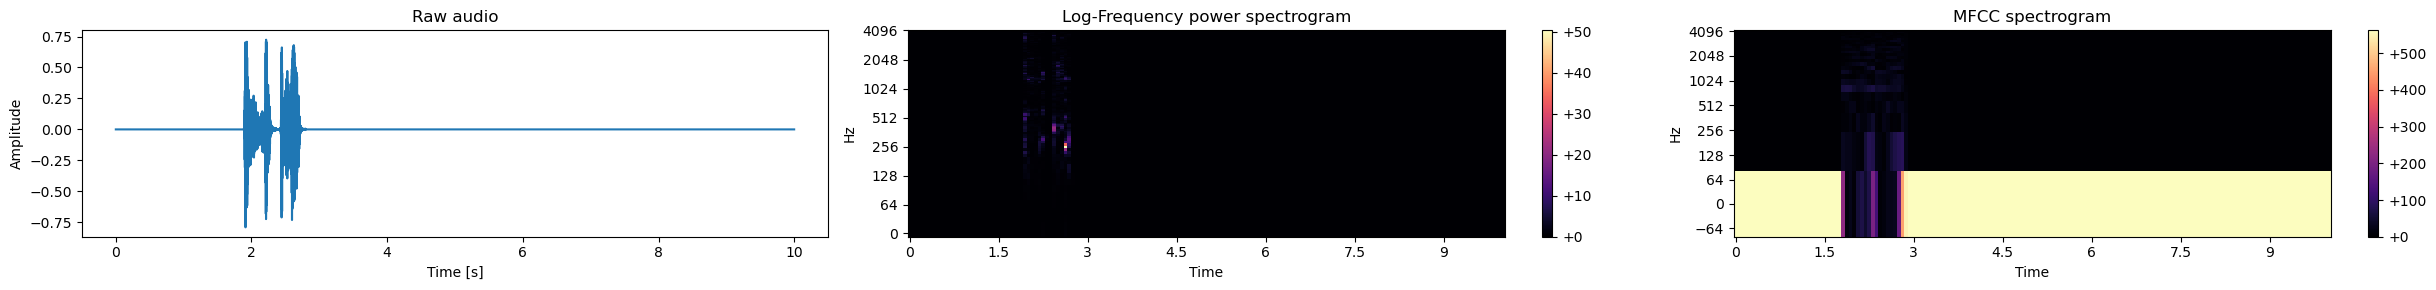

C:\Users\ACER-E5\AppData\Local\Temp\ipykernel_14060\4058687912.py:35: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [46]:
uuid = '56994aa1-4626-4782-9f27-f125adfd120a'
tmp_audiofilename = uuid+".wav"
        
tmp_df, tmp_audio, sr = import_raw_audio(tmp_audiofilename, sr=my_sampling_rate)
tmp_audio = zero_padding(tmp_audio, sr=sr, target_duration=target_duration)                                                         
stft , mfcc = calc_spectral_features(tmp_audio, sr, n_fft=my_n_fft,n_mfcc=my_n_mfcc,win_overlap=0.0)
freqs_welch, psx_welch = calc_power_spectrum_welch(tmp_audio,sr, my_n_fft)
        
print(mfcc.shape)
time_stamps = np.arange(0,target_duration, 1/my_sampling_rate)

# Plot raw signal
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 3))
axs[0].plot(time_stamps, tmp_audio)
axs[0].set_title('Raw audio')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Amplitude')

# Plot STFT
img0 = librosa.display.specshow(np.abs(stft), sr=sr, y_axis='log', x_axis='time', ax=axs[1])
axs[1].set_title('Log-Frequency power spectrogram')
fig.colorbar(img0, ax=axs[1], format="%+2.f")

# Plot MFCC
img1 = librosa.display.specshow(np.abs(mfcc), sr=sr, y_axis='log', x_axis='time', ax=axs[2])
axs[2].set_title('MFCC spectrogram')
fig.colorbar(img1, ax=axs[2], format="%+2.f")

plt.tight_layout()
plt.show()
#img0 = librosa_display.specshow(x, y_axis='log', x_axis='time',
#                               sr=my_sampling_rate, ax=ax)
ax.set_title('MFCC spectrogram', size=18)
fig.colorbar(img0, format="%+2.f")
fig.show()

# plot power spectrum
line_data = ply_go.Scatter(x=freqs_welch,#np.arange(0,target_duration,my_n_fft/(my_sampling_rate)), 
                           y=psx_welch,
                           name="Power Spectrum density", showlegend=False)
fig = ply_go.Figure(data=[line_data])#, layout=my_layout)
fig.update_layout(title={'text': "Power Spectrum Density (UUID:{})".format(uuid)}, 
                  xaxis={"title":{"text":"Frequency [Hz]"}}, yaxis={"title":{"text":"Average Power"}})
fig.show()


## Balanced data: Under Sampling

In [53]:
# the following looks more complicated than needed because I want first to keep all entries of the smallest group
# then upsample the difference between that and the target number n_resampling. No pandas function is allowing me to do this.
def sample_df_balanced(df, group_col, n, random=42):
    assert isinstance(group_col,str), "Input group_col must be a plain string with the column name: {}".format(type(group_col))
    #df_count = df[[group_col]].groupby([group_col]).cumcount()+1
    df['N'] = np.zeros(len(df[group_col]))
    df_count = df[[group_col,'N']].groupby([group_col]).count().reset_index() #cumcount()+1
    
    out_df = pd.DataFrame()
    for igroup in df[group_col].unique():

        n_orig = df_count.loc[df_count[group_col]==igroup,'N'].values[0]
        if n_orig < n: # need to upsample
            delta = max(n - n_orig, 0)
            tmp_df = df.loc[df[group_col]==igroup, ]
            delta_df = tmp_df.sample(n=delta,random_state=random,replace=False)
            out_df = pd.concat([out_df,tmp_df,delta_df])
        else: #downsample
            tmp_df = df.loc[df[group_col]==igroup, ].sample(n=n,random_state=random,replace=False)
            out_df = pd.concat([out_df,tmp_df])
    ### end for loop over groups
    return out_df.drop('N',axis=1,inplace=False)
### end sample_df_balanced

   

In [54]:
tmp_metadata = metadata.copy()
print("Before resampling, count of entries by STATUS class in the full data.frame:")
tmp_metadata_count = tmp_metadata[['uuid','status']].groupby(['status']).count()
print(tmp_metadata_count)
print(len(tmp_metadata.loc[tmp_metadata['status']=='COVID-19', 'uuid'].unique()))

# every group will have a number of entries equal to the number of records 
# in the smallest group, rounded to the closest ten above
n_resampling = int(np.ceil(tmp_metadata_count['uuid'].min()/10)*10)

  
    
#tmp_metadata = tmp_metadata.groupby(['status']).sample(n=n_resampling,random_state=42,replace=False)
tmp_metadata = sample_df_balanced(tmp_metadata, 'status', n_resampling) #tmp_metadata.groupby(['status']).sample(n=n_resampling,random_state=42,replace=False)
print("\nAfter resampling, count of entries by STATUS class in the full data.frame:")
print(tmp_metadata[['uuid','status']].groupby(['status']).count())
print(len(tmp_metadata.loc[tmp_metadata['status']=='COVID-19', 'uuid'].unique()))


Before resampling, count of entries by STATUS class in the full data.frame:
             uuid
status           
COVID-19      699
healthy      8300
symptomatic  1820
699

After resampling, count of entries by STATUS class in the full data.frame:
             uuid
status           
COVID-19      700
healthy       700
symptomatic   700
699


In [55]:

all_data, all_audio_metadata, mfcc_array, label = prepare_data(input_data=tmp_metadata, audio_datadir="archive/", sr=my_sampling_rate, 
                                                  target_duration=target_duration, n_fft=my_n_fft, n_mfcc=my_n_mfcc, 
                                                  fft_window_size=my_window_size, psd_freq_bins=my_psd_freqs,
                                                  mfcc_feature_names=mfcc_feature_names, psd_feature_names=psd_feature_names,
                                                  max_audio_samples=None, print_every_n=20) 

all_audio_metadata = all_audio_metadata.drop_duplicates(subset='UUID', keep='first') # this avoids spurious duplicates at the following merge

print("Merging dataframe with audio features and df with audio metadata")
all_data = pd.merge(all_data,all_audio_metadata,on=['UUID'],how='inner')
all_data.drop(['AUDIO_FILE'],axis=1,inplace=True)

#print(all_data[['UUID','STATUS']].groupby(['STATUS']).count())
print("Shape of full dataframe with features and labels: {}".format(all_data.shape))
all_data.head(10)



Processing file #0: b6265178-88ad-4b1e-aeb3-2fdcbf50c41c.wav
Processing file #20: 4e23bcf1-9774-4ff5-937c-e112e6e78ac1.wav
Processing file #40: ede35ff1-5bcc-45e3-8b37-42f8166e9f2a.wav
Processing file #60: a98bb5cf-cc0a-433e-9afd-ba755116d532.wav
Processing file #80: 9c7c8a21-88ed-4360-b49f-d310159317fa.wav
Processing file #100: 75bbed81-c05e-4494-aef2-7ec567b5a4a8.wav
Processing file #120: bc9ba87c-6dd2-47b0-abd9-ee3266a49387.wav
Processing file #140: a2a7d46c-a5d1-49bf-9125-20c4fcd436ec.wav
Processing file #160: da831084-379f-4fcd-9a29-1ce8a9599b6b.wav
Processing file #180: ff4b2677-6a66-43e2-9437-04793c8925a6.wav
Processing file #200: 072fdfd5-9418-4db4-88e5-8a574b40d51e.wav
Processing file #220: 38ae20db-67d2-4efa-a804-3841abb668b9.wav
Processing file #240: 722dcf78-c87f-4e14-abc7-c9578c1186ea.wav
Processing file #260: 9a205b2f-8627-4961-bfeb-405461abcb75.wav
Processing file #280: 2b537f15-4937-49f8-8528-96d1e0231236.wav
Processing file #300: fd7abe76-5225-4b45-aede-3e680bb95a92.wa

UUID  COUGH_DETECTED        SNR   AGE  \
0  b6265178-88ad-4b1e-aeb3-2fdcbf50c41c          0.8625   6.070167  29.0   
1  b316d3f9-2a05-4ead-b7a5-8cdab0e6a02c          0.9284  19.640098  34.0   
2  7a7c2f1a-2924-47e1-bc90-ac8c4029c6e1          0.9249   7.920975  54.0   
3  563e505c-9706-426a-a791-14a7814b4278          0.9853  35.703204  42.0   
4  90ba15f9-693b-4cca-aea0-958f67a98df1          0.8244  13.307407   n/a   
5  3938fac1-ae70-4148-90ea-59abb26459c1          1.0000   0.000000   n/a   
6  3832577b-853a-48c9-a3a1-30401e64e93e          0.8740   4.001763  55.0   
7  f2d5ad83-91b7-4efe-9bc9-4adf3a08cf7d          0.9583   0.000000  30.0   
8  8602e16f-5ba1-49ac-9095-ccd4f4c356a3          0.9717  45.204792  55.0   
9  da71535e-5a96-401c-aaa3-1eb43c5331d2          0.8974   7.288313  23.0   

   GENDER  RESPIRATORY_CONDITION  FEVER_MUSCLE_PAIN   STATUS  MFCC_MEAN_00  \
0  female                   True              False  healthy   -314.276896   
1    male                  False              False  healthy   -573.406992   
2    male                  False              False  healthy   -556.255353   
3    male                  False              False  healthy   -506.145541   
4  female                  False              False  healthy   -448.925864   
5  female                  False              False  healthy   -596.314651   
6    male                  False              False  healthy   -333.474139   
7    male                  False              False  healthy   -668.714046   
8    male                  False              False  healthy   -499.275516   
9    male                  False              False  healthy   -538.864046   

   MFCC_MEAN_01  ...  SPEC_SKEW_04  SPEC_SKEW_05  SPEC_SKEW_06  SPEC_SKEW_07  \
0     26.323522  ...    188.651388    -11.867006      7.121968     -4.238686   
1     13.491453  ...    237.842726    -10.022541    -26.537727    -16.312403   
2     12.318852  ...     40.956896    -21.442705      9.467030    -16.582881   
3      6.508743  ...    179.726840     -7.643919     -8.739489      8.439267   
4     22.256000  ...     35.603659    -14.214201    -27.232914    -14.537110   
5      7.537700  ...     14.605300    -25.471222      7.084418      1.521389   
6      6.566888  ...    102.018500     19.963971     -2.039693    -11.613636   
7     11.682780  ...     13.759184     -9.258694     -8.638574      8.368206   
8     17.263168  ...    156.897048      6.571587      1.449242     18.405543   
9     31.412310  ...     38.945655      9.522347     10.261808     -0.844815   

        ZCR  SAMPLING_RATE  DURATION  MEAN_SIG   MAX_SIG   MIN_SIG  
0  0.097559           8192  9.900024  0.000004  0.779338 -0.803159  
1  0.195642           8192  9.900024 -0.000012  0.753404 -0.752729  
2  0.053662           8192  9.900024  0.000023  0.664487 -0.612250  
3  0.164014           8192  7.440063 -0.000005  0.819486 -0.821491  
4  0.129346           8192  4.920044 -0.000009  0.950985 -0.929356  
5  0.019043           8192  2.100098 -0.000081  0.737675 -0.736065  
6  0.063611           8192  9.765381  0.000002  0.876330 -0.931353  
7  0.057031           8192  9.180054  0.000005  0.333029 -0.293048  
8  0.137817           8192  9.840088 -0.000020  1.004147 -0.963849  
9  0.127832           8192  9.960083  0.000008  0.260654 -0.150818  

[10 rows x 114 columns]

In [56]:
for col in all_data.columns:
    print(col)
print(len(all_data.columns))

UUID
COUGH_DETECTED
SNR
AGE
GENDER
RESPIRATORY_CONDITION
FEVER_MUSCLE_PAIN
STATUS
MFCC_MEAN_00
MFCC_MEAN_01
MFCC_MEAN_02
MFCC_MEAN_03
MFCC_MEAN_04
MFCC_MEAN_05
MFCC_MEAN_06
MFCC_MEAN_07
MFCC_MEAN_08
MFCC_MEAN_09
MFCC_MEAN_10
MFCC_MEAN_11
MFCC_MEAN_12
MFCC_MEAN_13
MFCC_MEAN_14
MFCC_MEAN_15
MFCC_MEAN_16
MFCC_MEAN_17
MFCC_MEAN_18
MFCC_MEAN_19
MFCC_MEAN_20
MFCC_MEAN_21
MFCC_MEAN_22
MFCC_MEAN_23
MFCC_MEAN_24
MFCC_MEAN_25
MFCC_SD_00
MFCC_SD_01
MFCC_SD_02
MFCC_SD_03
MFCC_SD_04
MFCC_SD_05
MFCC_SD_06
MFCC_SD_07
MFCC_SD_08
MFCC_SD_09
MFCC_SD_10
MFCC_SD_11
MFCC_SD_12
MFCC_SD_13
MFCC_SD_14
MFCC_SD_15
MFCC_SD_16
MFCC_SD_17
MFCC_SD_18
MFCC_SD_19
MFCC_SD_20
MFCC_SD_21
MFCC_SD_22
MFCC_SD_23
MFCC_SD_24
MFCC_SD_25
SPEC_CENTROID_00
SPEC_CENTROID_01
SPEC_CENTROID_02
SPEC_CENTROID_03
SPEC_CENTROID_04
SPEC_CENTROID_05
SPEC_CENTROID_06
SPEC_CENTROID_07
SPEC_WIDTH_00
SPEC_WIDTH_01
SPEC_WIDTH_02
SPEC_WIDTH_03
SPEC_WIDTH_04
SPEC_WIDTH_05
SPEC_WIDTH_06
SPEC_WIDTH_07
SPEC_CREST_00
SPEC_CREST_01
SPEC_CREST_02
SPEC

In [57]:
out_data_filename = 'archive/'+"/cough-classification-data_Class{}.pkl"
pd.to_pickle(all_data, out_data_filename)  # save df to file
#all_data = pd.read_pickle(out_data_filename) # load df from file

### one more check that all covid status are balanced
all_data[['UUID','STATUS']].groupby(['STATUS']).count().rename(columns={'UUID':'N_UUID'})


N_UUID
STATUS             
COVID-19        700
healthy         700
symptomatic     700

In [58]:
sampled_data = all_data.copy()
all_uuids = sampled_data['UUID'].values

#select X features to be used in ML classification
#train_features = (['RESPIRATORY_CONDITION', 'FEVER_MUSCLE_PAIN','MEAN_SIG','MAX_SIG','MIN_SIG','ZCR']+
#                  [ f for f in sampled_data.columns.values if f.startswith('MFCC_')] + 
#                  [ f for f in sampled_data.columns.values if f.startswith('SPEC_')])

max_freq_features = 99
train_features = (['RESPIRATORY_CONDITION', 'FEVER_MUSCLE_PAIN','MEAN_SIG','MAX_SIG','MIN_SIG','ZCR']+
                  [f2 for f2 in [ f1 for f1 in sampled_data.columns.values  if f1.startswith('MFCC_')] if int(f2[-2:])<max_freq_features]+
                  [f2 for f2 in [ f1 for f1 in sampled_data.columns.values  if f1.startswith('SPEC_')] if int(f2[-2:])<max_freq_features])

y_label = 'STATUS'

### this is used if one wants to reduce the number of classes/status; 
#sampled_data.loc[sampled_data['STATUS']=='symptomatic','STATUS'] = 'NOCOVID' 
#sampled_data.loc[sampled_data['STATUS']=='healthy','STATUS']     = 'NOCOVID' 


#print(train_features)
print("Number of training X features: {}".format(len(train_features)) )
X_train, X_test, y_train, y_test, uuid_train, uuid_test = train_test_split(sampled_data[train_features].values, sampled_data[[y_label]].values, all_uuids,
                                                                            test_size=0.3,random_state=612, stratify=sampled_data[y_label])
print("Shapes of train X and y datasets: X->{}    y->{}".format(X_train.shape ,y_train.shape))
print("Shapes of test  X and y datasets: X->{}    y->{}".format(X_test.shape, y_test.shape))


print("\n\nTRAIN DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid={}\n\n".format(y_train[y_train=="healthy"].shape[0], y_train[y_train=="symptomatic"].shape[0], y_train[y_train=="COVID-19"].shape[0]))

Number of training X features: 106
Shapes of train X and y datasets: X->(1470, 106)    y->(1470, 1)
Shapes of test  X and y datasets: X->(630, 106)    y->(630, 1)


TRAIN DATASET - Count of entries by STATUS:
healthy=490 	symptomatic=490 	covid=490




In [59]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

labenc = LabelEncoder()
y_train_enc = labenc.fit_transform(y_train.ravel())
y_enc_labels = labenc.classes_
print(y_enc_labels)
y_test_enc = labenc.transform(y_test.ravel())

# Tìm các dòng chứa giá trị NaN trong X_train_norm
nan_rows_train = np.isnan(X_train_norm).any(axis=1)

# Xóa các dòng chứa giá trị NaN từ X_train_norm và y_train_enc
X_train_norm = X_train_norm[~nan_rows_train]
y_train_enc = y_train_enc[~nan_rows_train]

# Tương tự cho X_test_norm và y_test_enc
nan_rows_test = np.isnan(X_test_norm).any(axis=1)
X_test_norm = X_test_norm[~nan_rows_test]
y_test_enc = y_test_enc[~nan_rows_test]

y_test_enc.shape


['COVID-19' 'healthy' 'symptomatic']


(630,)

Logistic model accuracy / precision / recall: 0.433 / 0.433 / 0.433



              precision    recall  f1-score   support

    COVID-19       0.44      0.41      0.43       210
     healthy       0.43      0.54      0.48       210
 symptomatic       0.42      0.34      0.38       210

    accuracy                           0.43       630
   macro avg       0.43      0.43      0.43       630
weighted avg       0.43      0.43      0.43       630



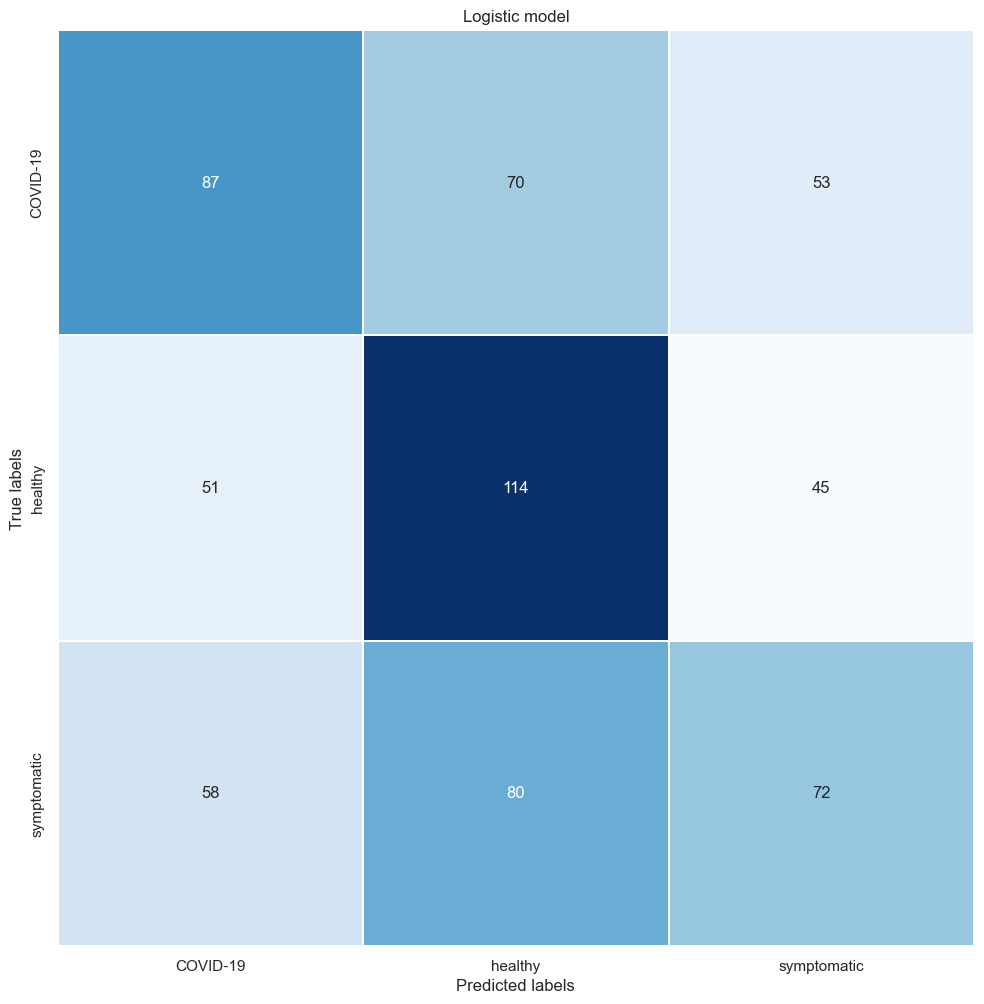

In [60]:
### SETUP LOGISTIC REGRESSION (MULTICLASS)
from sklearn.linear_model import LogisticRegression
logit_params = dict(multi_class='multinomial', penalty='l2', C=0.20, solver='newton-cg', random_state=991)

logit_class = LogisticRegression(**logit_params)
logit_model = logit_class.fit(X_train_norm, y_train_enc)
logit_test  = logit_model.predict(X_test_norm )

evaluate_matrix(y_test_enc, logit_test, 'Logistic model')

SVM model accuracy / precision / recall: 0.446 / 0.446 / 0.446



              precision    recall  f1-score   support

    COVID-19       0.46      0.47      0.47       210
     healthy       0.44      0.51      0.47       210
 symptomatic       0.44      0.36      0.39       210

    accuracy                           0.45       630
   macro avg       0.45      0.45      0.44       630
weighted avg       0.45      0.45      0.44       630



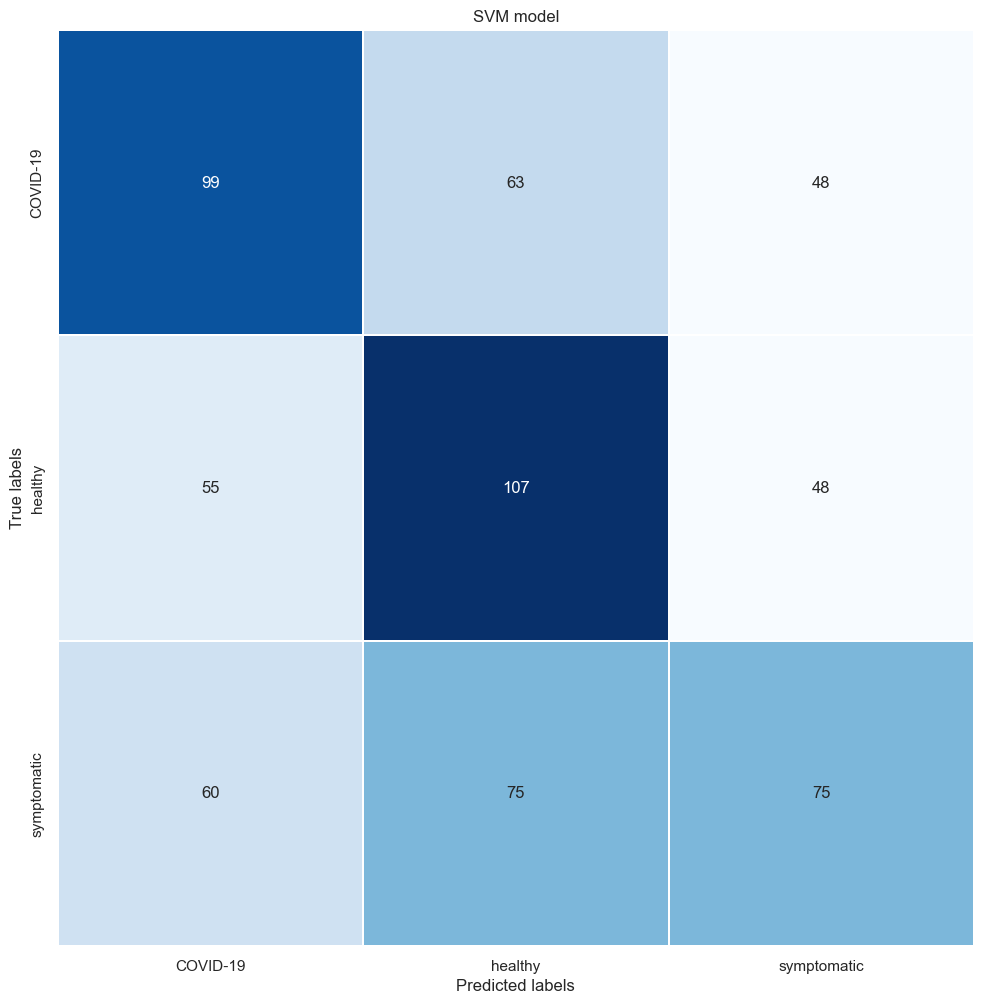

In [61]:
from sklearn.svm import SVC
svm_params = dict(C=10, kernel='rbf', random_state=991, class_weight='balanced')

svm_class = SVC(**svm_params)
svm_model = svm_class.fit(X_train_norm, y_train_enc)
svm_test  = svm_model.predict(X_test_norm )

evaluate_matrix(y_test_enc, svm_test, 'SVM model')

KNN model accuracy / precision / recall: 0.416 / 0.418 / 0.416



              precision    recall  f1-score   support

    COVID-19       0.41      0.49      0.44       210
     healthy       0.49      0.43      0.46       210
 symptomatic       0.35      0.33      0.34       210

    accuracy                           0.42       630
   macro avg       0.42      0.42      0.42       630
weighted avg       0.42      0.42      0.42       630



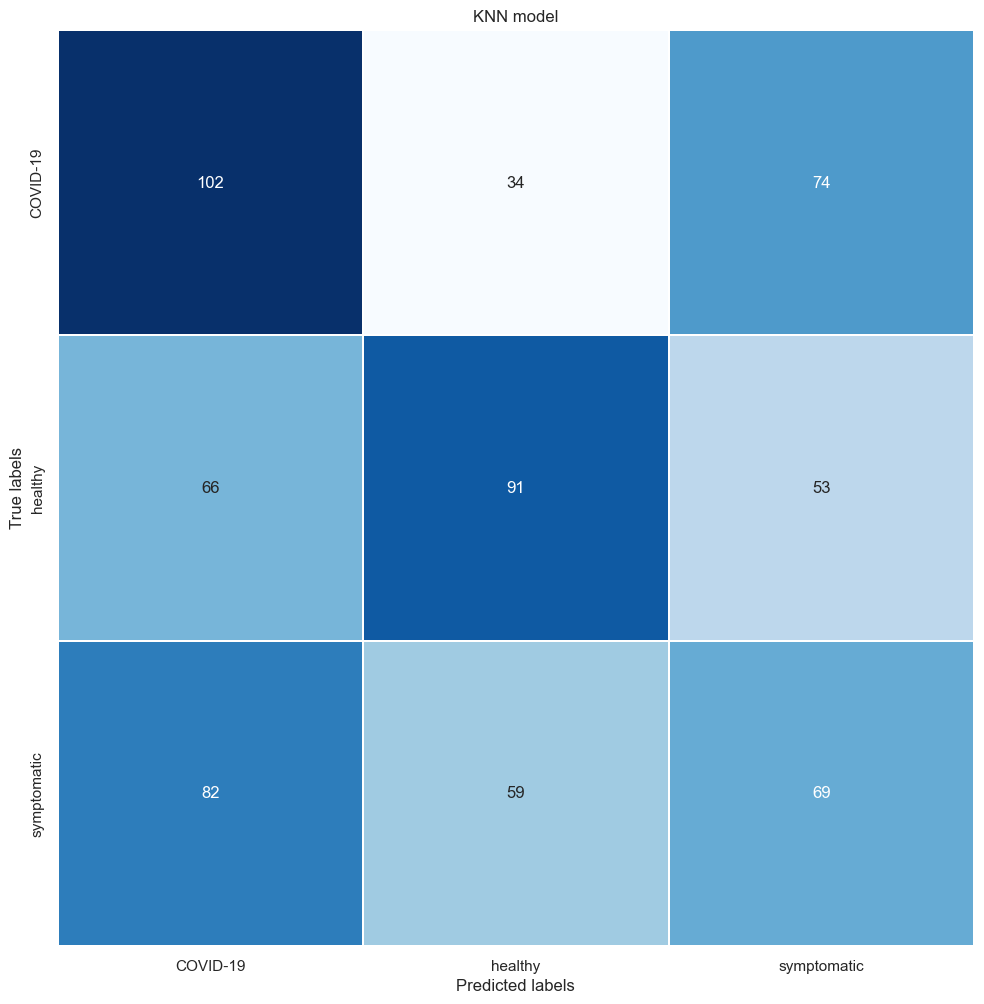

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = dict(n_neighbors=3, weights='distance')

knn_class = KNeighborsClassifier(**knn_params)
knn_model = knn_class.fit(X_train_norm, y_train_enc)
knn_test = knn_model.predict(X_test_norm)

evaluate_matrix(y_test_enc, knn_test, 'KNN model')

In [70]:
from keras import models
from keras import *
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.5)))

#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)))

model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))

model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.05)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               54784     
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 3)                 51        
                                                                 
Total params: 228355 (892.01 KB)
Trainable params: 228

In [71]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_norm,
                    y_train_enc,
                    epochs=100,
                    batch_size=128,
                   validation_split=0.15)

Epoch 1/100
10/10 [==============================] - 2s 41ms/step - loss: 43.0243 - accuracy: 0.3507 - val_loss: 39.1335 - val_accuracy: 0.3891
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 36.3359 - accuracy: 0.4876 - val_loss: 32.9668 - val_accuracy: 0.4118
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 30.5487 - accuracy: 0.4796 - val_loss: 27.6450 - val_accuracy: 0.4932
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 25.6073 - accuracy: 0.4948 - val_loss: 23.1519 - val_accuracy: 0.4842
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 21.4278 - accuracy: 0.5100 - val_loss: 19.3772 - val_accuracy: 0.4615
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 17.9208 - accuracy: 0.4612 - val_loss: 16.2164 - val_accuracy: 0.4389
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 14.9593 - accuracy: 0.5132 - val_loss: 13.5360 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


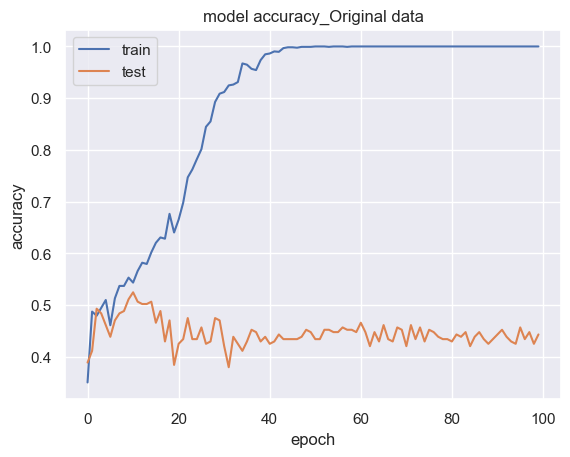

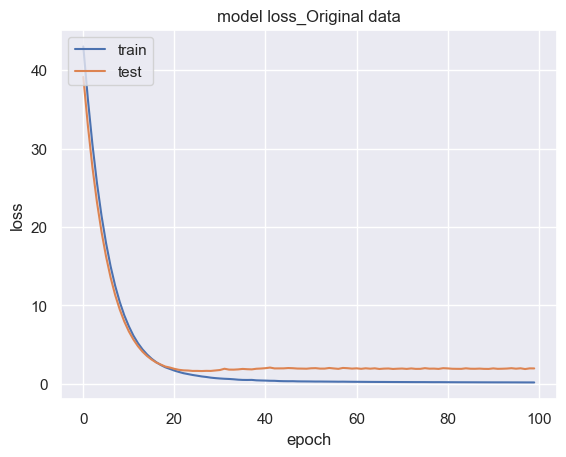

In [72]:
history_loss_acc(history, 'Original data')

In [73]:
test_loss, test_acc = model.evaluate(X_test_norm, y_test_enc)

20/20 [==============================] - 0s 4ms/step - loss: 2.0700 - accuracy: 0.4302


In [74]:
predictions = model.predict(X_test_norm)

20/20 [==============================] - 0s 3ms/step


Neural Network model accuracy / precision / recall: 0.430 / 0.431 / 0.430



              precision    recall  f1-score   support

    COVID-19       0.42      0.50      0.46       210
     healthy       0.45      0.40      0.42       210
 symptomatic       0.42      0.39      0.40       210

    accuracy                           0.43       630
   macro avg       0.43      0.43      0.43       630
weighted avg       0.43      0.43      0.43       630



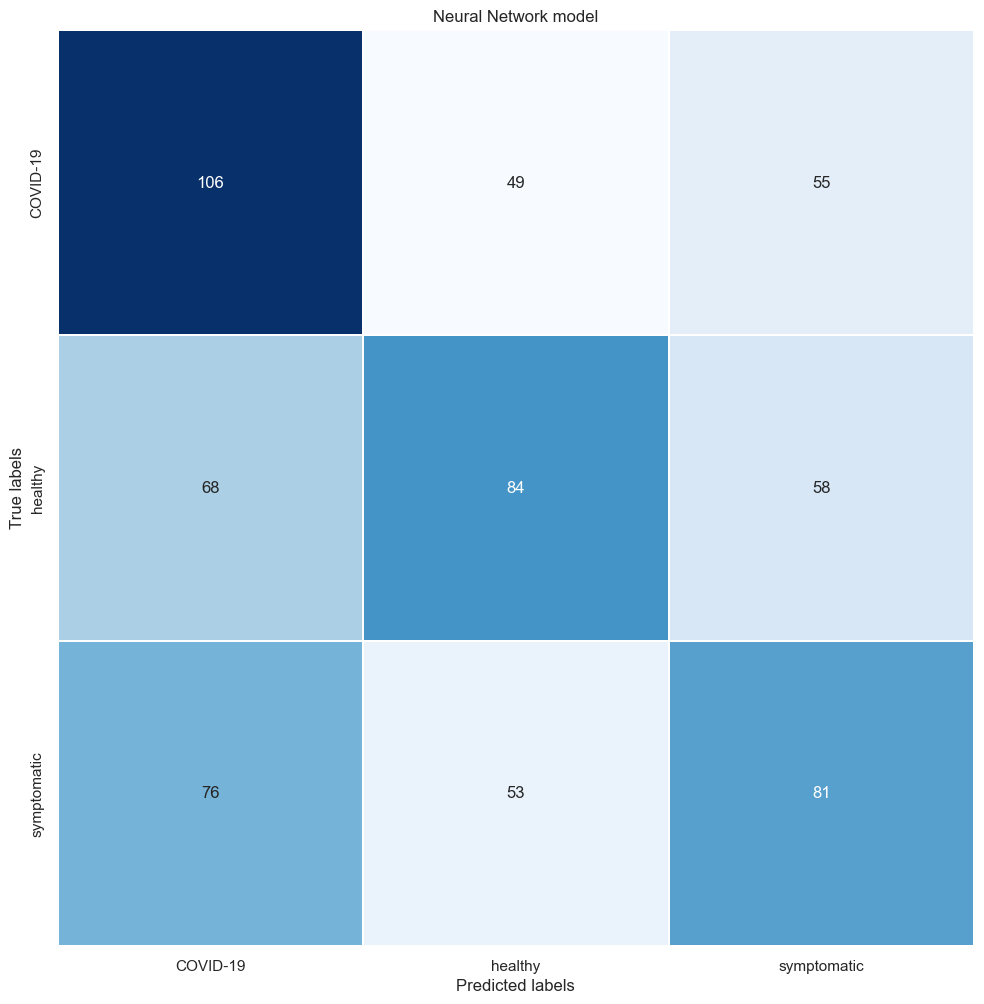

In [75]:
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)

evaluate_matrix(y_test_enc, y_predict, 'Neural Network model')

In [267]:
X = mfcc_array
y = label

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=612, shuffle=True)

print("Shapes of train X and y datasets: X->{}    y->{}".format(X_train.shape ,y_train.shape))
print("Shapes of test  X and y datasets: X->{}    y->{}".format(X_test.shape, y_test.shape))

print("\n\nTRAIN DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid19={}\n\n".format(y_train[y_train==1].shape[0], y_train[y_train==2].shape[0], y_train[y_train==0].shape[0]))
print("\n\nTEST DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid19={}\n\n".format(y_test[y_test==1].shape[0], y_test[y_test==2].shape[0], y_test[y_test==0].shape[0]))

# Feature dimension
feature_dim_1 = 26
# Second dimension of the feature is dim2
feature_dim_2 = 161
channel = 1

Shapes of train X and y datasets: X->(1407, 26, 161)    y->(1407,)
Shapes of test  X and y datasets: X->(693, 26, 161)    y->(693,)


TRAIN DATASET - Count of entries by STATUS:
healthy=473 	symptomatic=464 	covid19=470




TEST DATASET - Count of entries by STATUS:
healthy=227 	symptomatic=236 	covid19=230




In [268]:
# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train = y_train
y_test = y_test

In [269]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 160, 48)       240       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 159, 64)       12352     
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 158, 64)       16448     
                                                                 
 batch_normalization (Batch  (None, 23, 158, 64)       256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 79, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 78, 128)     

In [270]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128,
                   validation_split=0.15)

Epoch 1/100
10/10 [==============================] - 29s 3s/step - loss: 10.2954 - accuracy: 0.3414 - val_loss: 7.1131 - val_accuracy: 0.3349
Epoch 2/100
10/10 [==============================] - 26s 3s/step - loss: 6.5042 - accuracy: 0.3531 - val_loss: 5.7644 - val_accuracy: 0.3491
Epoch 3/100
10/10 [==============================] - 26s 3s/step - loss: 5.2658 - accuracy: 0.3347 - val_loss: 4.6641 - val_accuracy: 0.3302
Epoch 4/100
10/10 [==============================] - 25s 2s/step - loss: 4.3019 - accuracy: 0.3297 - val_loss: 3.8497 - val_accuracy: 0.3302
Epoch 5/100
10/10 [==============================] - 22s 2s/step - loss: 3.5889 - accuracy: 0.3297 - val_loss: 3.2664 - val_accuracy: 0.3302
Epoch 6/100
10/10 [==============================] - 21s 2s/step - loss: 3.0804 - accuracy: 0.3297 - val_loss: 2.8491 - val_accuracy: 0.3302
Epoch 7/100
10/10 [==============================] - 21s 2s/step - loss: 2.7139 - accuracy: 0.3297 - val_loss: 2.5445 - val_accuracy: 0.3302
Epoch 8/100


Epoch 59/100
10/10 [==============================] - 27s 3s/step - loss: 1.0337 - accuracy: 0.7715 - val_loss: 1.7069 - val_accuracy: 0.3632
Epoch 60/100
10/10 [==============================] - 25s 2s/step - loss: 0.9193 - accuracy: 0.8285 - val_loss: 1.7394 - val_accuracy: 0.3538
Epoch 61/100
10/10 [==============================] - 26s 3s/step - loss: 0.9518 - accuracy: 0.8184 - val_loss: 1.9002 - val_accuracy: 0.3302
Epoch 62/100
10/10 [==============================] - 23s 2s/step - loss: 0.9587 - accuracy: 0.8393 - val_loss: 1.9142 - val_accuracy: 0.3774
Epoch 63/100
10/10 [==============================] - 26s 3s/step - loss: 0.9265 - accuracy: 0.8477 - val_loss: 1.9347 - val_accuracy: 0.3491
Epoch 64/100
10/10 [==============================] - 25s 2s/step - loss: 0.8835 - accuracy: 0.8661 - val_loss: 2.0028 - val_accuracy: 0.3632
Epoch 65/100
10/10 [==============================] - 27s 3s/step - loss: 0.8685 - accuracy: 0.8703 - val_loss: 1.9110 - val_accuracy: 0.3726
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


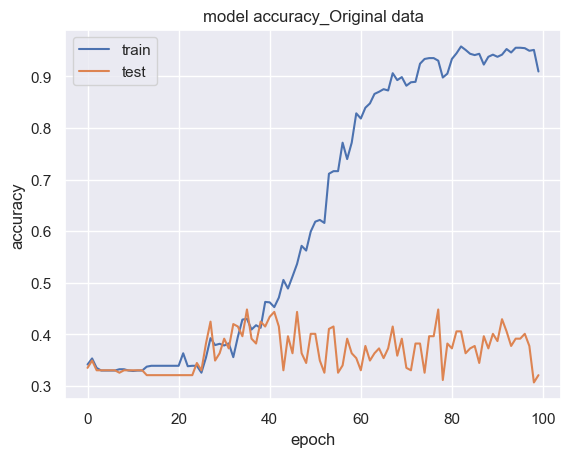

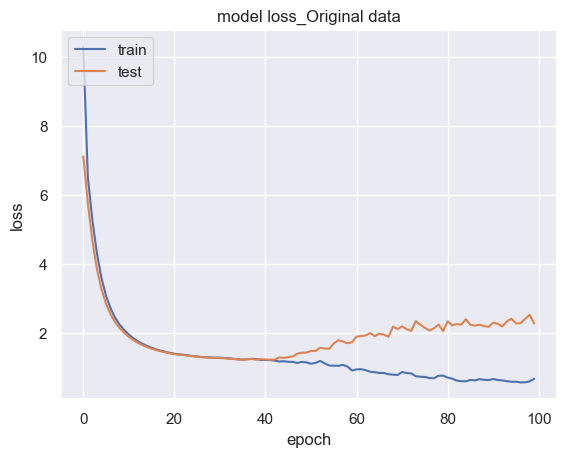

In [271]:
history_loss_acc(history, 'Original data')

In [272]:
test_loss, test_acc = model.evaluate(X_test, y_test)

22/22 [==============================] - 2s 112ms/step - loss: 2.2546 - accuracy: 0.3665


In [273]:
predictions = model.predict(X_test)

22/22 [==============================] - 2s 90ms/step


CNN model accuracy / precision / recall: 0.367 / 0.367 / 0.366



              precision    recall  f1-score   support

    COVID-19       0.36      0.10      0.16       230
     healthy       0.34      0.52      0.41       227
 symptomatic       0.41      0.48      0.44       236

    accuracy                           0.37       693
   macro avg       0.37      0.37      0.34       693
weighted avg       0.37      0.37      0.34       693



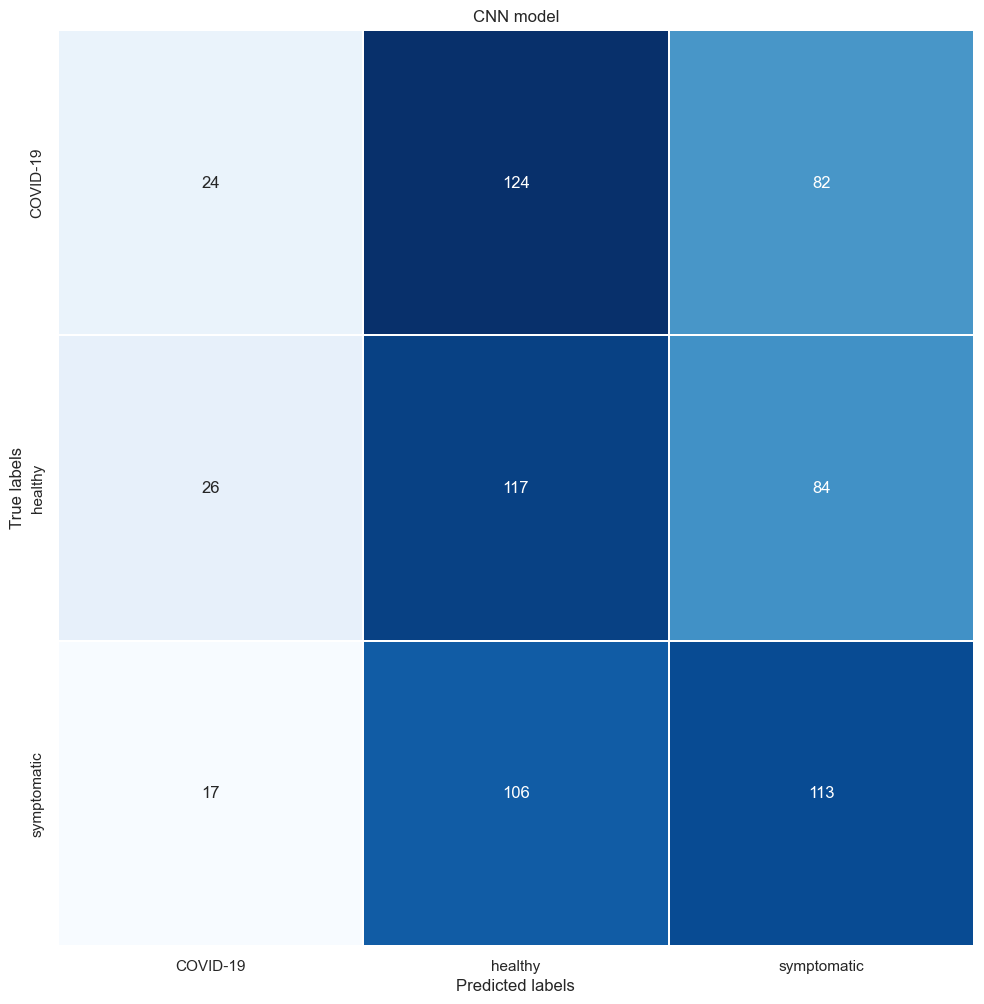

In [274]:
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)

evaluate_matrix(y_test, y_predict, 'CNN model')

## Balanced data: Over Sampling

#### Lấy 3000 mẫu healthy

In [50]:
tmp_metadata = metadata.copy()
print("Before resampling, count of entries by STATUS class in the full data.frame:")
tmp_metadata_count = tmp_metadata[['uuid','status']].groupby(['status']).count()
print(tmp_metadata_count)
print(len(tmp_metadata.loc[tmp_metadata['status']=='COVID-19', 'uuid'].unique()))

# Chọn ngẫu nhiên 3000 mẫu nhãn 'healthy'
healthy_samples = tmp_metadata[tmp_metadata['status'] == 'healthy'].sample(n=3000, random_state=42)
other_samples = tmp_metadata[tmp_metadata['status'] != 'healthy']
tmp_metadata = pd.concat([healthy_samples, other_samples])

print("\nAfter resampling, count of entries by STATUS class in the full data.frame:")
print(tmp_metadata[['uuid','status']].groupby(['status']).count())
print(len(tmp_metadata.loc[tmp_metadata['status']=='COVID-19', 'uuid'].unique()))

Before resampling, count of entries by STATUS class in the full data.frame:
             uuid
status           
COVID-19      608
healthy      7905
symptomatic  1778
608

After resampling, count of entries by STATUS class in the full data.frame:
             uuid
status           
COVID-19      608
healthy      3000
symptomatic  1778
608


In [51]:
all_data, all_audio_metadata, mfcc_array, label = prepare_data(input_data=tmp_metadata, audio_datadir="archive/", sr=my_sampling_rate, 
                                                  target_duration=target_duration, n_fft=my_n_fft, n_mfcc=my_n_mfcc, 
                                                  fft_window_size=my_window_size, psd_freq_bins=my_psd_freqs,
                                                  mfcc_feature_names=mfcc_feature_names, psd_feature_names=psd_feature_names,
                                                  max_audio_samples=None, print_every_n=20) 

all_audio_metadata = all_audio_metadata.drop_duplicates(subset='UUID', keep='first') # this avoids spurious duplicates at the following merge

print("Merging dataframe with audio features and df with audio metadata")
all_data = pd.merge(all_data,all_audio_metadata,on=['UUID'],how='inner')
all_data.drop(['AUDIO_FILE'],axis=1,inplace=True)

#print(all_data[['UUID','STATUS']].groupby(['STATUS']).count())
print("Shape of full dataframe with features and labels: {}".format(all_data.shape))
all_data.head(10)

Processing file #0: 702f974c-fa86-4a1e-99dc-016d9fffbb6b.wav
Processing file #20: b49e6406-5f9b-4e8b-924b-c00c7b40b0aa.wav
Processing file #40: 6f8c98c1-aa56-402a-8fbc-fd9d35947d83.wav
Processing file #60: be53aed3-5771-4cb6-af3b-1c95dfed2ae5.wav
Processing file #80: feb65011-50f0-4ccd-9913-dc41a2a02766.wav
Processing file #100: 135e55a6-abaa-40b5-9d40-632e5636eb53.wav
Processing file #120: e8f9178e-30b1-45b8-bde1-b4f00c4b4883.wav
Processing file #140: b81a5168-9886-40d5-9fd3-a11ce28bee1b.wav
Processing file #160: 4afdbe2a-920c-4592-8149-ed315f7a20ae.wav
Processing file #180: ef9bfd48-ddf2-4ddb-8479-f6d1c3bcfa07.wav
Processing file #200: b97cb5a8-e327-4d61-9242-70b2407d7f6d.wav
Processing file #220: e3ed5bd4-8c89-4856-9735-0f5bba41e32a.wav
Processing file #240: c237d349-eb56-44c7-84df-41b69412cf94.wav
Processing file #260: 7cd5afde-1c1c-4dae-98d1-b31fa41b411f.wav
Processing file #280: 10f3e05b-dd2a-4eba-bd09-c24cf6ad2cf7.wav
Processing file #300: 73d15d3f-7490-4072-a2ef-b0bd7c547ed2.wa

Processing file #2580: 31a33c5f-db24-4c18-8eed-d999fb8f1e17.wav
Processing file #2600: d4aaba45-9530-4703-8286-6c3e44ce965d.wav
Processing file #2620: 02877709-f7ea-4789-9526-1e1f47cafb3f.wav
Processing file #2640: 9bdcb1c5-0f5d-4891-90e4-6748a835b9ce.wav
Processing file #2660: ef0dfde5-ec56-4b9b-b8d3-12429a9431bb.wav
Processing file #2680: 19389b33-e02b-40b4-ae93-a15999c8cef7.wav
Processing file #2700: 8e66dfdd-ad53-46f8-92a7-0882378d4081.wav
Processing file #2720: 03cfc75c-88a0-4ca9-8ca4-4aa61e2dec37.wav
Processing file #2740: 24d95dfb-d6a8-4ff9-b117-88a16ee2efa2.wav
Processing file #2760: 6c3f15de-9efd-4fc5-a06b-5cd6ea06d4da.wav
Processing file #2780: 96622641-4cb1-4c15-9193-8ec854c2a67c.wav
Processing file #2800: fa319312-3eb5-4f2b-9237-387537bdd742.wav
Processing file #2820: 12e5943b-6d1a-4e83-90ca-0892b4ba4246.wav
Processing file #2840: 368740ec-b992-47a7-9a1b-ba8fbf41c8f5.wav
Processing file #2860: 65df392a-658b-48ac-9daa-12ec477ba858.wav
Processing file #2880: b9693d70-b932-424

Processing file #5160: e8527a0e-96c9-4026-96c2-3b3a3508f3ee.wav
Processing file #5180: ea3553b7-8fc4-4889-bc48-9318dfc1c9f5.wav
Processing file #5200: eca68eb8-13f3-4190-a865-019e88d8b83b.wav
Processing file #5220: ee19a294-20c1-47ae-870a-245a25595bc9.wav
Processing file #5240: eff08b1e-fc39-40e4-a807-7b2651644a8a.wav
Processing file #5260: f1e01206-3362-412f-8025-fb07ca64b1d7.wav
Processing file #5280: f40a70d1-7923-4e5e-b16b-2cfab8c23b93.wav
Processing file #5300: f5e3c403-1588-49ad-8984-47f123f941f8.wav
Processing file #5320: f73d615e-0c05-454c-a505-52ef2c1c2865.wav
Processing file #5340: f99a8315-236c-483b-8222-449dea88604a.wav
Processing file #5360: fd849b72-f4bf-4852-9bc2-fd9becc9571e.wav
Processing file #5380: ff49f6b7-fa54-4780-a4be-b0594e628aae.wav

5386 files processed in 399.3 seconds

Merging dataframe with audio features and df with audio metadata
Shape of full dataframe with features and labels: (5386, 115)


UUID AUDIO_CLASS  COUGH_DETECTED  \
0  702f974c-fa86-4a1e-99dc-016d9fffbb6b           C          0.9689   
1  0f1d05f5-1d1f-452c-be28-fb0c7b8085c4           C          1.0000   
2  0ed0b9bd-afbb-4869-8c06-55204afc8ff2           C          0.9543   
3  9e5f0bd4-0b0f-45d8-8a30-942d16ebd737           B          0.9192   
4  bf4abbe9-0b22-4baf-bf37-a89aaefef925           C          0.8392   
5  371fce60-ce5a-4003-9396-e4acddc42184           C          0.9937   
6  fb3e67fd-8b81-49f0-b6fb-178903f2c79a           C          1.0000   
7  b498e61d-fedb-4a57-badc-52b398143f26           C          0.8461   
8  74797c09-59db-41b1-9efc-cc0788c4eb63           C          0.8629   
9  70785418-cef3-4f88-b3b8-6388980479c5           B          0.9462   

         SNR   AGE  GENDER  RESPIRATORY_CONDITION  FEVER_MUSCLE_PAIN   STATUS  \
0  17.776066  23.0    male                  False              False  healthy   
1   0.000000  32.0    male                  False              False  healthy   
2  26.567519  35.0    male                  False              False  healthy   
3   7.689604  48.0    male                  False              False  healthy   
4  47.400675  24.0    male                  False              False  healthy   
5  48.241682  29.0  female                  False              False  healthy   
6  18.385735  18.0    male                   True              False  healthy   
7  19.019077  29.0    male                  False              False  healthy   
8   2.251486  30.0  female                  False              False  healthy   
9  10.801820  50.0    male                   True              False  healthy   

   MFCC_MEAN_00  ...  SPEC_SKEW_04  SPEC_SKEW_05  SPEC_SKEW_06  SPEC_SKEW_07  \
0   -515.275776  ...    248.825441    -21.218156     15.612279     18.328665   
1   -519.208660  ...     19.375261      1.883960     -6.108002     10.390723   
2   -420.000864  ...      9.737792    -10.709983     23.536913    -10.995361   
3   -342.068307  ...     31.194019     -4.541128     22.505111     13.069247   
4   -566.540465  ...     80.999479     -7.634693      3.093674     11.372770   
5   -502.887731  ...    113.714258    -10.489580     -1.902866      3.957184   
6   -433.623294  ...     93.115108      3.085044     21.966789     18.379784   
7   -328.227007  ...     55.417943     -2.440953      9.928482    -22.935757   
8   -441.505270  ...     44.147364     20.313051    -23.193696     -5.152145   
9   -401.241303  ...     54.159004     -8.132215     10.891655     -7.144139   

        ZCR  SAMPLING_RATE  DURATION  MEAN_SIG   MAX_SIG   MIN_SIG  
0  0.101831           8192  4.840088 -0.000116  0.884763 -0.793554  
1  0.121289           8192  9.900024 -0.000009  0.874080 -0.918875  
2  0.174121           8192  9.780029  0.000014  0.820066 -0.877263  
3  0.170837           8192  9.900024 -0.000006  0.920545 -0.874471  
4  0.037109           8192  4.140015 -0.000011  0.783703 -0.701084  
5  0.119910           8192  9.480103  0.000019  0.724664 -0.736325  
6  0.107556           8192  9.900024 -0.000031  0.820968 -0.808200  
7  0.127332           8192  9.960083  0.000003  0.888162 -0.857011  
8  0.121863           8192  5.340088  0.000004  1.007173 -0.856086  
9  0.121741           8192  7.740112 -0.000067  0.865668 -0.874686  

[10 rows x 115 columns]

In [52]:
out_data_filename = 'archive/'+"/cough-classification-data_Class{}.pkl"
pd.to_pickle(all_data, out_data_filename)  # save df to file
#all_data = pd.read_pickle(out_data_filename) # load df from file

### one more check that all covid status are balanced
all_data[['UUID','STATUS']].groupby(['STATUS']).count().rename(columns={'UUID':'N_UUID'})


N_UUID
STATUS             
COVID-19        608
healthy        3000
symptomatic    1778

#### Sử dụng SMOTE để over sampling data

In [54]:
from collections import Counter
sampled_data = all_data.copy()

# Chọn các đặc trưng (features)
max_freq_features = 99
train_features = (['RESPIRATORY_CONDITION', 'FEVER_MUSCLE_PAIN', 'MEAN_SIG', 'MAX_SIG', 'MIN_SIG', 'ZCR'] +
                  [f2 for f2 in sampled_data.columns if f2.startswith('MFCC_') and int(f2[-2:]) < max_freq_features] +
                  [f2 for f2 in sampled_data.columns if f2.startswith('SPEC_') and int(f2[-2:]) < max_freq_features])
X_data = sampled_data[train_features]

y_label = 'STATUS'
y_data = sampled_data[y_label]

# Sử dụng SMOTE để oversample
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_data, y_data)

# In số lượng mẫu của từng lớp sau khi oversample
print(sorted(Counter(y_resampled).items()))

[('COVID-19', 3000), ('healthy', 3000), ('symptomatic', 3000)]


In [57]:
X_train, X_test, y_train, y_test, = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=612, stratify=y_resampled
)

print("Shapes of train X and y datasets: X->{}    y->{}".format(X_train.shape, y_train.shape))
print("Shapes of test  X and y datasets: X->{}    y->{}".format(X_test.shape, y_test.shape))

print("\n\nTRAIN DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid={}\n\n".format(
    y_train[y_train == "healthy"].shape[0],
    y_train[y_train == "symptomatic"].shape[0],
    y_train[y_train == "COVID-19"].shape[0],
))

Shapes of train X and y datasets: X->(6300, 106)    y->(6300,)
Shapes of test  X and y datasets: X->(2700, 106)    y->(2700,)


TRAIN DATASET - Count of entries by STATUS:
healthy=2100 	symptomatic=2100 	covid=2100




In [58]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

labenc = LabelEncoder()
y_train_enc = labenc.fit_transform(y_train.ravel())
y_enc_labels = labenc.classes_
print(y_enc_labels)
y_test_enc = labenc.transform(y_test.ravel())

# Tìm các dòng chứa giá trị NaN trong X_train_norm
nan_rows_train = np.isnan(X_train_norm).any(axis=1)

# Xóa các dòng chứa giá trị NaN từ X_train_norm và y_train_enc
X_train_norm = X_train_norm[~nan_rows_train]
y_train_enc = y_train_enc[~nan_rows_train]

# Tương tự cho X_test_norm và y_test_enc
nan_rows_test = np.isnan(X_test_norm).any(axis=1)
X_test_norm = X_test_norm[~nan_rows_test]
y_test_enc = y_test_enc[~nan_rows_test]

y_test_enc.shape

['COVID-19' 'healthy' 'symptomatic']


(2700,)

#### Logistic Regression

Logistic model accuracy / precision / recall: 0.545 / 0.548 / 0.545



              precision    recall  f1-score   support

    COVID-19       0.56      0.53      0.54       900
     healthy       0.53      0.72      0.61       900
 symptomatic       0.55      0.39      0.46       900

    accuracy                           0.55      2700
   macro avg       0.55      0.55      0.54      2700
weighted avg       0.55      0.55      0.54      2700



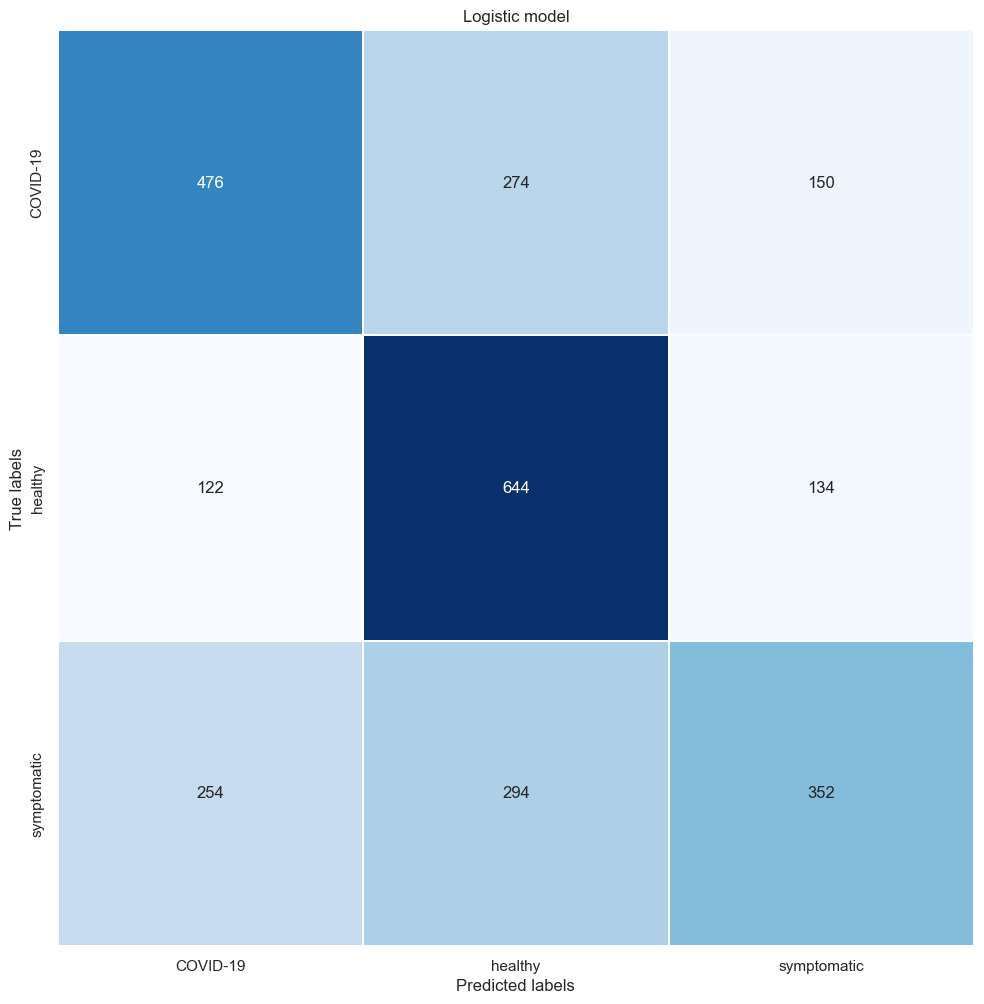

In [61]:
### SETUP LOGISTIC REGRESSION (MULTICLASS)
from sklearn.linear_model import LogisticRegression
logit_params = dict(multi_class='multinomial', penalty='l2', C=0.20, solver='newton-cg', random_state=991, class_weight='balanced')

logit_class = LogisticRegression(**logit_params)
logit_model = logit_class.fit(X_train_norm, y_train_enc)
logit_test  = logit_model.predict(X_test_norm )

evaluate_matrix(y_test_enc, logit_test, 'Logistic model')

#### SVM

SVM model accuracy / precision / recall: 0.704 / 0.704 / 0.704



              precision    recall  f1-score   support

    COVID-19       0.79      0.83      0.81       900
     healthy       0.64      0.71      0.67       900
 symptomatic       0.69      0.58      0.63       900

    accuracy                           0.70      2700
   macro avg       0.70      0.70      0.70      2700
weighted avg       0.70      0.70      0.70      2700



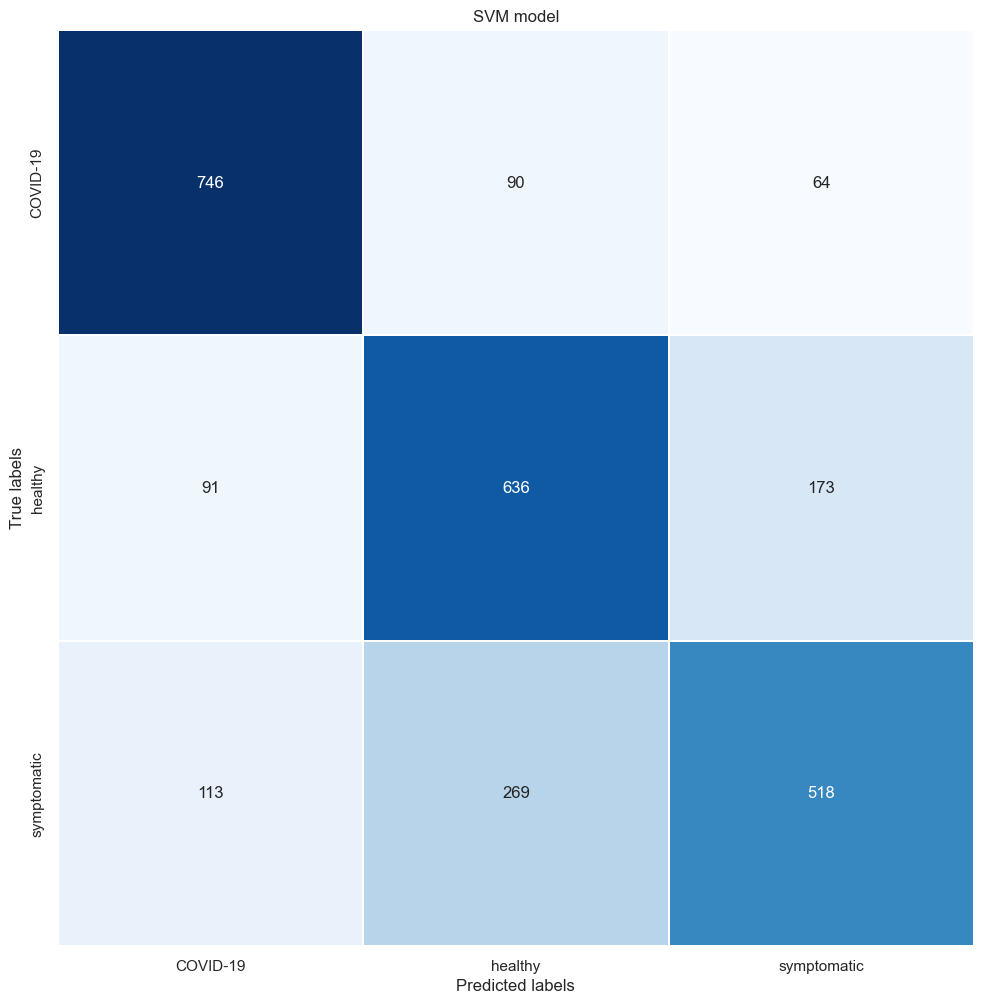

In [62]:
from sklearn.svm import SVC
svm_params = dict(C=10, kernel='rbf', random_state=991, class_weight='balanced')

svm_class = SVC(**svm_params)
svm_model = svm_class.fit(X_train_norm, y_train_enc)
svm_test  = svm_model.predict(X_test_norm )

evaluate_matrix(y_test_enc, svm_test, 'SVM model')

#### KNN

KNN model accuracy / precision / recall: 0.608 / 0.655 / 0.608



              precision    recall  f1-score   support

    COVID-19       0.56      0.96      0.70       900
     healthy       0.75      0.24      0.37       900
 symptomatic       0.66      0.62      0.64       900

    accuracy                           0.61      2700
   macro avg       0.65      0.61      0.57      2700
weighted avg       0.65      0.61      0.57      2700



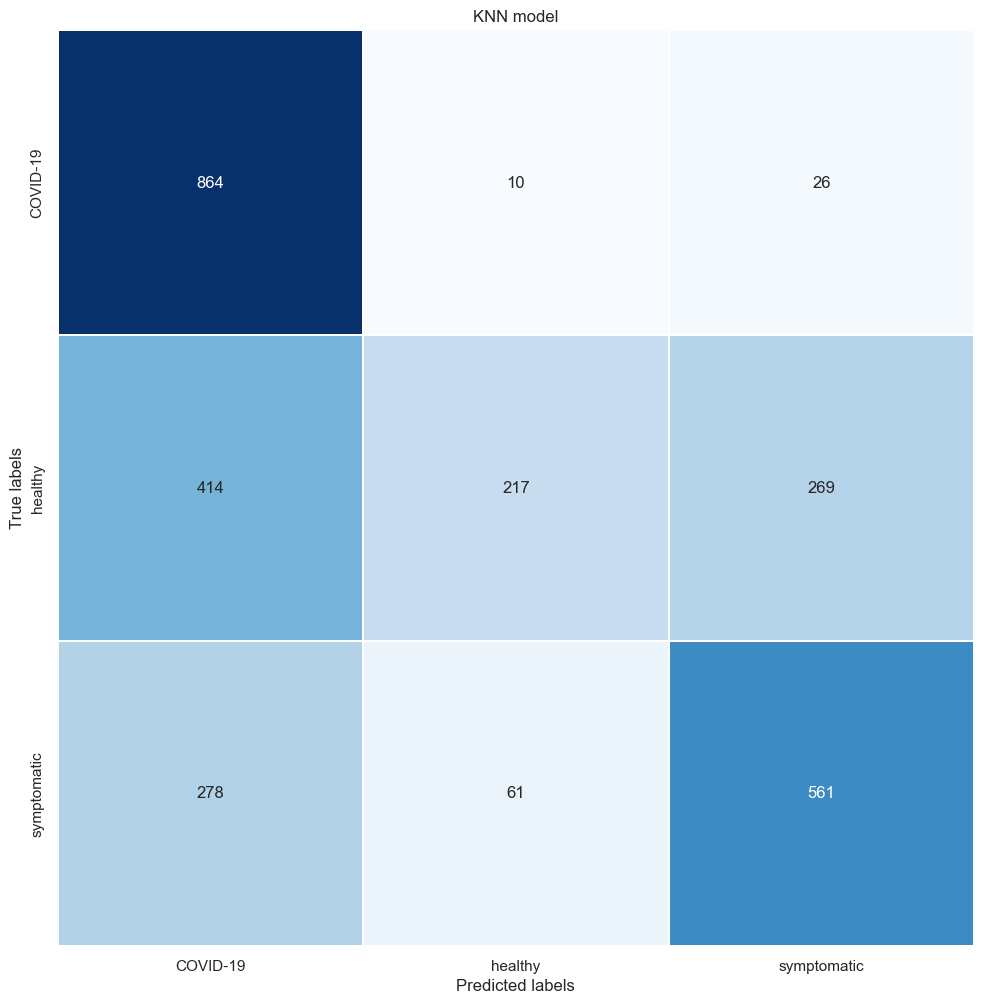

In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = dict(n_neighbors=3, weights='distance')

knn_class = KNeighborsClassifier(**knn_params)
knn_model = knn_class.fit(X_train_norm, y_train_enc)
knn_test = knn_model.predict(X_test_norm)

evaluate_matrix(y_test_enc, knn_test, 'KNN model')

#### Neural Network

In [86]:
from keras import models
from keras import *
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.5)))

#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)))

model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))

model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.05)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               54784     
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 16)                1040      
                                                                 
 dense_25 (Dense)            (None, 3)                 51        
                                                                 
Total params: 228355 (892.01 KB)
Trainable params: 228

In [87]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_norm,
                    y_train_enc,
                    epochs=100,
                    batch_size=128,
                   validation_split=0.15)

Epoch 1/100
42/42 [==============================] - 2s 14ms/step - loss: 33.5295 - accuracy: 0.4872 - val_loss: 22.4219 - val_accuracy: 0.5365
Epoch 2/100
42/42 [==============================] - 0s 8ms/step - loss: 15.8912 - accuracy: 0.5311 - val_loss: 10.4962 - val_accuracy: 0.5323
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 7.4790 - accuracy: 0.5255 - val_loss: 5.0258 - val_accuracy: 0.5450
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 3.7058 - accuracy: 0.5468 - val_loss: 2.6479 - val_accuracy: 0.5429
Epoch 5/100
42/42 [==============================] - 0s 10ms/step - loss: 2.1074 - accuracy: 0.5494 - val_loss: 1.6757 - val_accuracy: 0.5481
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 1.4681 - accuracy: 0.5529 - val_loss: 1.2974 - val_accuracy: 0.5767
Epoch 7/100
42/42 [==============================] - 0s 8ms/step - loss: 1.2134 - accuracy: 0.5703 - val_loss: 1.1540 - val_accuracy: 0.5566
Epoch 8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


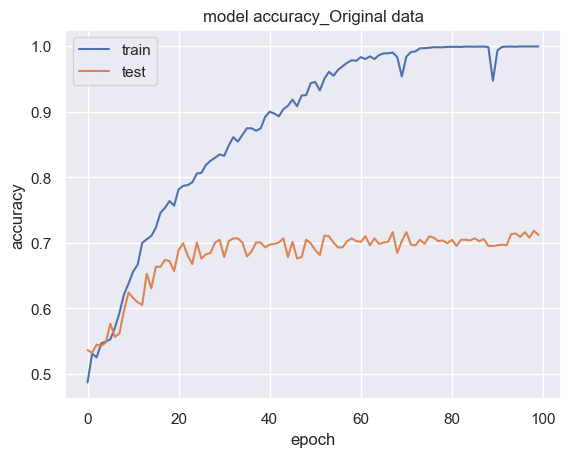

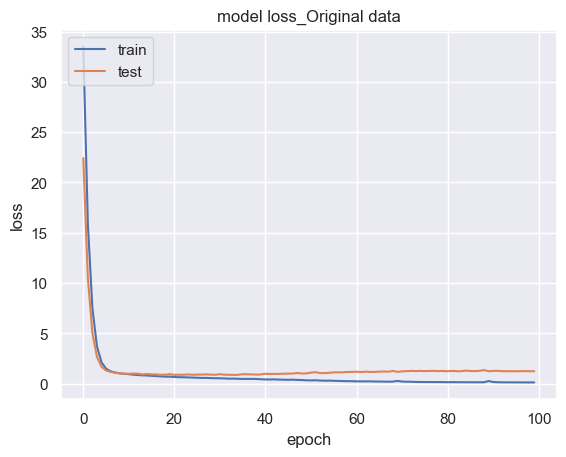

In [88]:
history_loss_acc(history, 'Original data')

In [89]:
test_loss, test_acc = model.evaluate(X_test_norm, y_test_enc)

85/85 [==============================] - 0s 3ms/step - loss: 1.2376 - accuracy: 0.7056


In [90]:
predictions = model.predict(X_test_norm)

85/85 [==============================] - 0s 3ms/step


Neural Network model accuracy / precision / recall: 0.706 / 0.707 / 0.706



              precision    recall  f1-score   support

    COVID-19       0.85      0.87      0.86       900
     healthy       0.67      0.57      0.62       900
 symptomatic       0.60      0.68      0.64       900

    accuracy                           0.71      2700
   macro avg       0.71      0.71      0.70      2700
weighted avg       0.71      0.71      0.70      2700



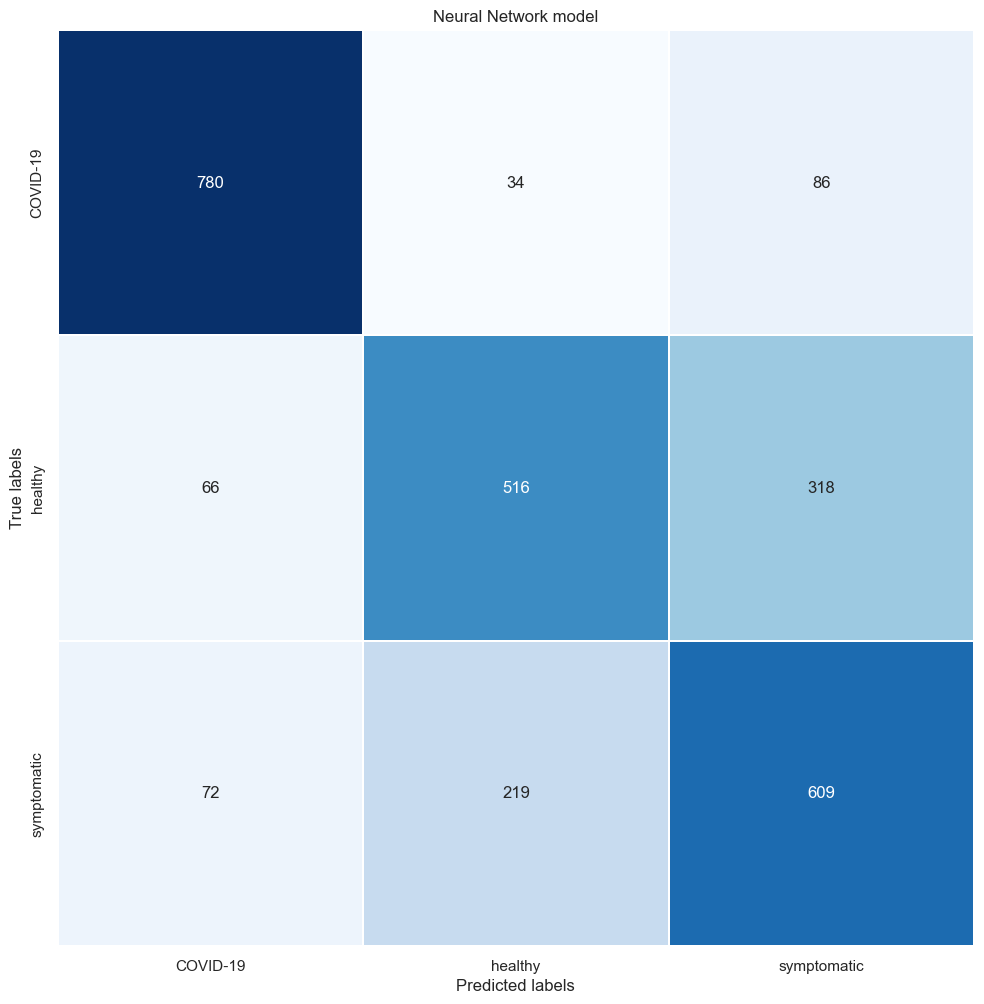

In [91]:
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)

evaluate_matrix(y_test_enc, y_predict, 'Neural Network model')

#### CNN

In [98]:
X = mfcc_array
y = label

X = np.array(X)
y = np.array(y)

# Flatten dữ liệu MFCCs
X_flat = np.concatenate(X).reshape(len(X), -1)

# Encode nhãn
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Sử dụng SMOTE để oversample
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_flat, y_encoded)

In [99]:
# Feature dimension
feature_dim_1 = 26
# Second dimension of the feature is dim2
feature_dim_2 = 161
channel = 1

In [100]:
# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=612, shuffle=True)

print("Shapes of train X and y datasets: X->{}    y->{}".format(X_train.shape, y_train.shape))
print("Shapes of test  X and y datasets: X->{}    y->{}".format(X_test.shape, y_test.shape))

print("\n\nTRAIN DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid19={}\n\n".format(
    np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 0)
))
print("\n\nTEST DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid19={}\n\n".format(
    np.sum(y_test == 1), np.sum(y_test == 2), np.sum(y_test == 0)
))

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)
y_train = y_train
y_test = y_test


Shapes of train X and y datasets: X->(6030, 4186)    y->(6030,)
Shapes of test  X and y datasets: X->(2970, 4186)    y->(2970,)


TRAIN DATASET - Count of entries by STATUS:
healthy=1987 	symptomatic=2006 	covid19=2037




TEST DATASET - Count of entries by STATUS:
healthy=1013 	symptomatic=994 	covid19=963




In [103]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 160, 48)       240       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 159, 64)       12352     
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 158, 64)       16448     
                                                                 
 batch_normalization_1 (Bat  (None, 23, 158, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 79, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 78, 128)      

In [104]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128,
                   validation_split=0.15)

Epoch 1/100
41/41 [==============================] - 112s 3s/step - loss: 7.7518 - accuracy: 0.3401 - val_loss: 4.5354 - val_accuracy: 0.3613
Epoch 2/100
41/41 [==============================] - 102s 2s/step - loss: 3.4990 - accuracy: 0.4404 - val_loss: 2.7557 - val_accuracy: 0.4144
Epoch 3/100
41/41 [==============================] - 103s 3s/step - loss: 2.3585 - accuracy: 0.5038 - val_loss: 2.1101 - val_accuracy: 0.4365
Epoch 4/100
41/41 [==============================] - 125s 3s/step - loss: 1.8814 - accuracy: 0.5255 - val_loss: 1.8371 - val_accuracy: 0.4530
Epoch 5/100
41/41 [==============================] - 114s 3s/step - loss: 1.6375 - accuracy: 0.5497 - val_loss: 1.6290 - val_accuracy: 0.5094
Epoch 6/100
41/41 [==============================] - 103s 3s/step - loss: 1.4818 - accuracy: 0.5723 - val_loss: 1.5804 - val_accuracy: 0.4994
Epoch 7/100
41/41 [==============================] - 115s 3s/step - loss: 1.3808 - accuracy: 0.6107 - val_loss: 1.4715 - val_accuracy: 0.5149
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


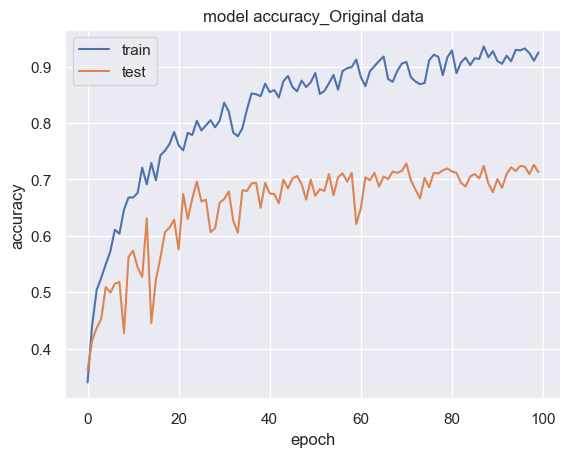

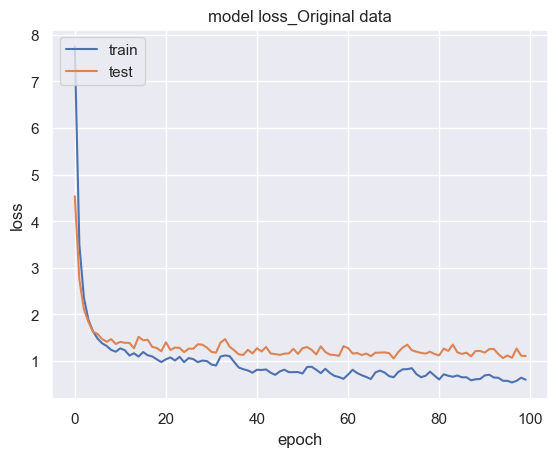

In [105]:
history_loss_acc(history, 'Original data')

In [106]:
test_loss, test_acc = model.evaluate(X_test, y_test)

93/93 [==============================] - 8s 89ms/step - loss: 1.1089 - accuracy: 0.7044


In [107]:
predictions = model.predict(X_test)

93/93 [==============================] - 8s 85ms/step


CNN model accuracy / precision / recall: 0.704 / 0.698 / 0.707



              precision    recall  f1-score   support

    COVID-19       0.81      0.93      0.86       963
     healthy       0.64      0.58      0.61      1013
 symptomatic       0.64      0.62      0.63       994

    accuracy                           0.70      2970
   macro avg       0.70      0.71      0.70      2970
weighted avg       0.70      0.70      0.70      2970



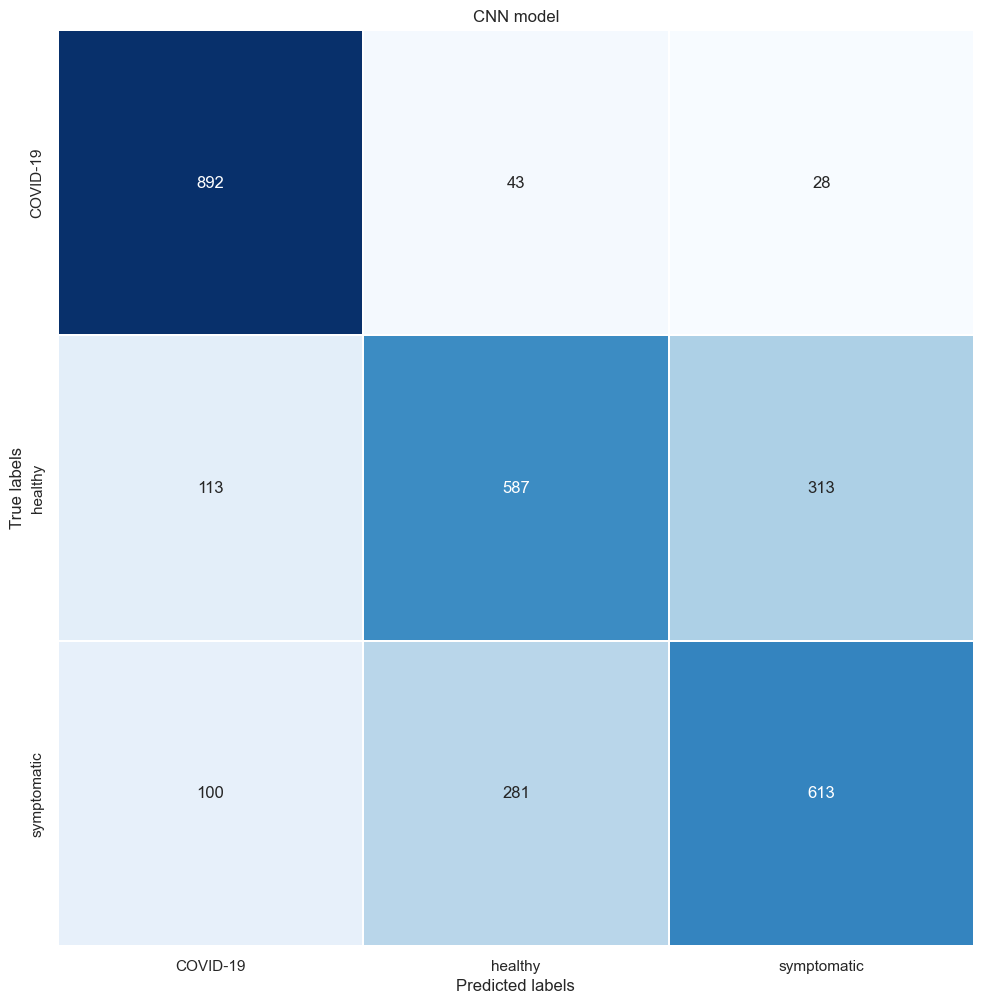

In [108]:
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)

evaluate_matrix(y_test, y_predict, 'CNN model')